# 2D DDW CC07 Group 2

## Acknowledgements
All members contributed equally to all portions of this 2D project.

## Group Members
1. Aditya 1005395
2. Aishwarya 1005762
3. Clement 1004988
4. Sean 1005122
5. Yuliati 1005644

# Contents <a id="contents"></a>

## General
1. [Import modules](#modules)
2. [Functions](#functions)
3. [Dataset](#dataset)

## Task 1
1. [Variable Definitions](#definitions-1)
2. [Data Pre-processing](#data-clean-1)
3. [Univariate Linear Regression](#univariate-1)
4. [Multivariate Variable Selection](#multivariate-selection-1)
5. Multivariate Linear Regression
    - [Variables with high correlation](#multivariate-high-1)
    - [Variables with low correlation](#multivariate-low-1)
    - [Variables with both high and low correlation](#multivariate-high-low-1)
    - [Feature transformation](#transformation-1)
    - [High correlation and transformed features](#combined-1)
    - [Conclusion](#summary-1)
6. [Text Only - NO CODE](#text-only-1)

## Task 2
1. [Problem Statement](#problem-statement)
2. [Variable Definitions](#definitions-2)
3. [Data Pre-processing](#data-clean-2)
4. [Dataset Limitations](#limitations-2)
5. [Univariate Linear Regression](#univariate-2)
6. [Multivariate Variable Selection](#multivariate-selection-2)
7. Multivariate Linear Regression
    - [Variables with high correlation](#multivariate-high-2)
    - [Feature transformation](#transformation-2)
    - [Further refinements](#further-refinements-2)
    - [Conclusion](#conclusion-2)

## Appendix
1. [Replacing missing values via forward propagation](#replace-1)
2. [Spotting linear correlation between independent variables - Task 1](#heatmap-1)
3. [Spotting linear correlation between independent variables - Task 2](#heatmap-2)

# Import Modules <a id="modules"></a>

[Back To Top](#contents)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from tabulate import tabulate

# Functions <a id='functions'></a>

The following cell initialises all the functions that we will be using in this notebook.

[Back To Top](#contents)

In [2]:
def printmd(string):
    '''Used for custom formatting of print statements'''
    display(Markdown(string))
    
def get_features_target(df, features, target):
    '''
    Retrieves corresponding columns from dataframe
    - df is the dataframe
    - features is an array
    - target is an array
    '''
    return df.loc[:, features], df.loc[:, target]

def prepare_features(df_features):
    '''
    1. Converts df_features into a 2d numpy array
    2. Adds a column of ones to df_features
    3. Returns df_features
    '''
    ones = np.ones((df_features.shape[0], 1))

    X = np.concatenate((ones, df_features.to_numpy()), axis=1)
    
    return X

def prepare_target(df_target):
    '''
    Converts df_target into a 2d numpy array and returns it
    '''
    
    target = df_target.to_numpy()
    
    return target

def normalise_z(df):
    '''Performs Z-score normalisation on specified dataframe'''
    mean = df.mean()
    std = df.std()
    return (df-mean)/std

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    '''Splits dataset into train and test set'''
    np.random.seed(random_state)
    
    n = int(df_feature.shape[0] * test_size)
    
    test_array = np.random.choice(df_feature.index.values, size=n, replace=False)
    
    df_feature_train = df_feature.iloc[~df_feature.index.isin(test_array)]
    df_feature_test = df_feature.iloc[df_feature.index.isin(test_array)]
    df_target_train = df_target.iloc[~df_target.index.isin(test_array)]
    df_target_test = df_target.iloc[df_target.index.isin(test_array)]

    return df_feature_train, df_feature_test, df_target_train, df_target_test

# Get predicted values, y, based on current beta
def predict(df_features, beta):
    '''Obtains predicted target values via linear regression algorithm'''
    df_features_norm = normalise_z(df_features)
    
    array_2d = prepare_features(df_features_norm)
    
    return np.matmul(array_2d, beta)

# Calculate cost
def compute_cost(X, y, beta):
    '''Computes cost based on current beta values'''
    m = X.shape[0]
    predicted = np.matmul(X, beta)
    
    J = 1/(2*m) * np.sum((predicted-y)**2)
    return J

# Minimise cost
def gradient_descent(X, y, beta, alpha, num_iters):
    '''Minimises cost via the gradient descent algorithm
    - X = Features
    - y = Target values
    - beta = Parameters
    - alpha = Step size
    - num_iters = Number of iterations'''
    
    m = X.shape[0]
    J_storage = []
    
    for _ in range(num_iters):
        predicted = np.matmul(X, beta)
        derivative_error = (1/m) * np.matmul(X.T, predicted-y)
        
        beta = beta - alpha * derivative_error
        J_storage.append(compute_cost(X, y, beta))
    
    
    return beta, J_storage

# Obtain r2_score
def r2_score(y, ypred):
    '''Calculate r2_score using sum of squared residuals (ss_res) and total sum of squares (ss_tot)'''
    y_ave = np.mean(y)
    ss_res = np.sum((y-ypred)**2)
    
    ss_tot = np.sum((y-y_ave)**2)
    
    return 1 - (ss_res/ss_tot)

# Obtain adjusted r2
def adjusted_r2_score(r2, N, p):
    '''
    - r2 is the value returned from r2_score()
    - N is the total sample size
    - p is the number of independent variables
    '''
    
    return 1 - ((1-r2)*(N-1)) / (N-p-1)

def get_r2_values(df, features, y, pred):
    '''
    Combines r2_score() and adjusted_r2_score() into one function to 
    - Print r2_score and adjusted_r2_score
    - Return r2_score and adjusted_r2_score
    '''
    r2 = r2_score(y, pred)
    adjusted_r2 = adjusted_r2_score(r2, y.shape[0], df.shape[1])
    title = ", ".join(features)
    
    printmd(f'''Features: **{title}**
1. r2_score is {r2}
2. adjusted_r2_score is {adjusted_r2}''')
    return r2, adjusted_r2

# Obtain MSE
def mean_squared_error(target, pred):
    n = target.shape[0]
    
    return 1/n * np.sum((target-pred)**2)

def format_df(df):
    '''
    Returns a new dataframe that calculates the mean across a 1-month period for each country
    '''

    ls = []
    loc_date = []

    # For each location
    for loc in df["location"].unique():
        # For each year
        for y in range(2020, 2022):
            # For each month
            for i in range(1, 13):
                date_filter = (pd.to_datetime(df['date']).dt.month == i) & (pd.to_datetime(df['date']).dt.year == y)
                location_filter = df["location"] == loc

                loc_date.append([loc, f'{i}-2021'])

                mean = df[date_filter].loc[location_filter].iloc[:, 2:].mean()
                ls.append(mean)
    
    # Convert to df
    month_mean_df = pd.DataFrame(ls, columns=df.columns)
    month_mean_df[["location", "date"]] = loc_date
    
    # Drop na
    df = month_mean_df.dropna()

    return df

def plot_data(df, y, pred, features, target_col):
    '''Plots scatterplot for each feature in features'''
    
    for i, f in enumerate(features):
        plot = plt.figure(i)
        plt.scatter(df[f], y)
        plt.scatter(df[f], pred)
        plt.xlabel(f)
        plt.ylabel(target_col[0])
        plt.show()
    
def lin_reg(df, features, target_col=["new_deaths_smoothed_per_million"], random_state=100, show_data_plot=True):
    '''
    Trains dataset according to gradient descent algorithm
    This function is dependent on
    - get_features_target()
    - split_data()
    - normalise_z()
    - prepare_features()
    - prepare_target()
    - get_r2_values()
    - gradient_descent()
    - predict()
    - plot_data()
    '''
    df_features, df_target = get_features_target(df, features, target_col)

    # Split data
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=random_state, test_size=0.3)

    # Normalise features
    df_features_train = normalise_z(df_features_train)

    # Prepare features, target
    X = prepare_features(df_features_train)
    target = prepare_target(df_target_train)

    # Initialise variables for gradient descent
    # Beta: num_features * 1 column
    beta = np.zeros((X.shape[1], 1))
    alpha = 0.01
    iterations = 1000

    # Minimise cost function via gradient descent algorithm
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
    
    # Plot total cost against number of iterations
    plt.plot(J_storage)
    
    # Get predicted values
    pred = predict(df_features_test, beta)
    
    # Prepare target
    target = prepare_target(df_target_test)
    
    # Calculate and return r2, adjusted_r2
    r2, adjusted_r2 = get_r2_values(df, features, target, pred)

    if show_data_plot:
        # For each feature, plot a scatterplot
        plot_data(df_features_test, target, pred, features, target_col)    
        
    return beta, r2, adjusted_r2

# Read Dataset <a id='dataset'></a>

Our dataset is taken from [Our World In Data](https://github.com/owid/covid-19-data) which is updated on a daily basis.

Our dataset was **last updated on 10th November 2021**.

[Back To Top](#contents)

In [3]:
# Read the CSV file
df = pd.read_csv("owid-covid-data.csv")



# Variable Selection & Definitions <a id='definitions-1'></a>
To predict `new_deaths_smoothed_per_million`, we experimented with the following independent variables. These variables were initially chosen through intellectual conjecture on what variables are most likely to affect `new_deaths_smoothed_per_million`. Subsequently, we elaborated on the steps taken to ensure we picked variables that were the most linearly related to `new_deaths_smoothed_per_million`.

## Independent Variables
1. `icu_patients_per_million` = Number of COVID-19 patients in intensive care units (ICUs) on a given day per 1,000,000 people
2. `new_cases_smoothed_per_million` = New confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people
3. `stringency_index` = Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)
4. `median_age` = Median age of the population, UN projection for 2020
5. `extreme_poverty` = Share of the population living in extreme poverty, most recent year available since 2010
6. `people_fully_vaccinated_per_hundred` = Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population
7. `people_vaccinated_per_hundred` = Total number of people who received at least one vaccine dose per 100 people in the total population
8. `reproduction_rate` = Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database
9. `human_development_index` = A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506

## Dependent Variable
1. `new_deaths_smoothed_per_million` = New deaths attributed to COVID-19 (7-day smoothed) per 1,000,000 people

[Back To Top](#contents)

# Data pre-processing <a id='data-clean-1'></a>

## Attempt 1 - Forward fill
We attempted to replace missing values using both the forward fill and backward fill techniques. However, this resulted in a much poorer linear correlation between our independent and dependent variables. [See our Appendix for the numerical calculations](#replace-1).


## Attempt 2 - Dropping missing values
As > 95% of the data points contain rows that have missing values, we decided to drop the rows with missing values altogether as filling them up through either forward or backward propagation would inevitably skew the data points towards a more unnatural result. This also produced a more favourable linear correlation between our independent and dependent variables which will be shown in our next section.

We processed the data by 
1. Extracting out columns containing our independent and dependent variables
2. Dropping rows with missing values

[Back To Top](#contents)

In [4]:
useful_cols = ["location", "date", "icu_patients_per_million", "new_cases_smoothed_per_million", "stringency_index", "median_age", "extreme_poverty", "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "reproduction_rate", "human_development_index", "new_deaths_smoothed_per_million"]

df_useful = df[useful_cols]

# Drop rows with nan
df_dropna_one = df_useful.dropna()

print(f"Original sample size is {df_useful.shape[0]}. After dropping missing values, the number of data points is {df_useful.dropna().shape[0]}")


Original sample size is 132016. After dropping missing values, the number of data points is 4539


# Univariate Linear Regression <a id='univariate-1'></a>

For reliability purposes, a random_state of 100 has been set. `r2` and `adjusted_r2` values have been sorted in ascending order.

|                                       |         r2 |   adjusted_r2 |
|:--------------------------------------|-----------:|--------------:|
| `icu_patients_per_million`            | 0.595933   |    0.590514   |
| `new_cases_smoothed_per_million`      | 0.277922   |    0.268237   |
| `stringency_index`                    | 0.116847   |    0.105001   |
| `median_age`                          | 0.00456267 |   -0.00878895 |
| `extreme_poverty`                     | 0.0200249  |    0.00688066 |
| `people_fully_vaccinated_per_hundred` | 0.179166   |    0.168156   |
| `people_vaccinated_per_hundred`       | 0.225711   |    0.215326   |
| `reproduction_rate`                   | 0.044482   |    0.0316658  |
| `human_development_index`             | 0.06814    |    0.0556411  |

## Analysis
All `adjusted_r2_score`, excluding that of `new_cases_smoothed_per_million` experienced a drastic drop in values. We believe this is likely due to the data set containing far too many rows with missing values. For future improvements, we will be choosing a data set with lesser empty rows.  

[Back To Top](#contents)

Features: **icu_patients_per_million**
1. r2_score is 0.5959332013218808
2. adjusted_r2_score is 0.592336167505755

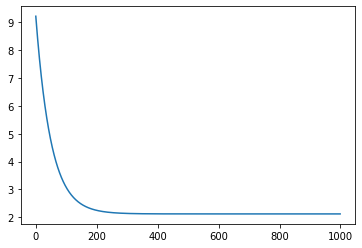

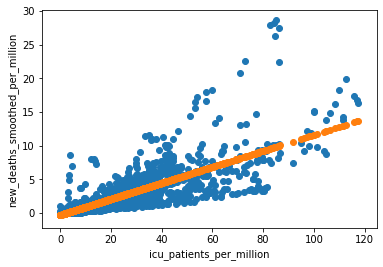

Features: **new_cases_smoothed_per_million**
1. r2_score is 0.277922392580796
2. adjusted_r2_score is 0.2714944020102986

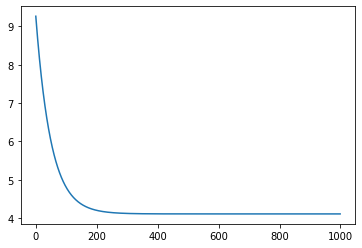

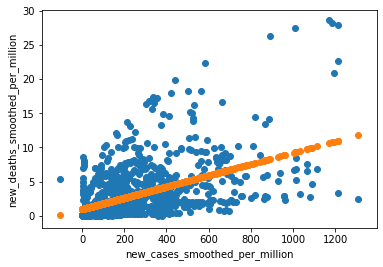

Features: **stringency_index**
1. r2_score is 0.11684654483557266
2. adjusted_r2_score is 0.1089846446412307

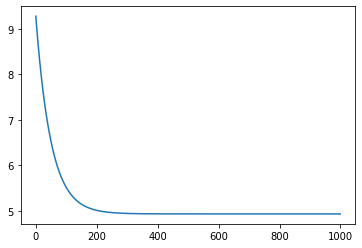

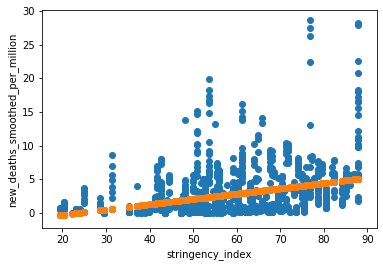

Features: **median_age**
1. r2_score is 0.004562667711661805
2. adjusted_r2_score is -0.00429879221968843

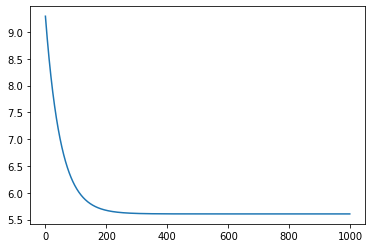

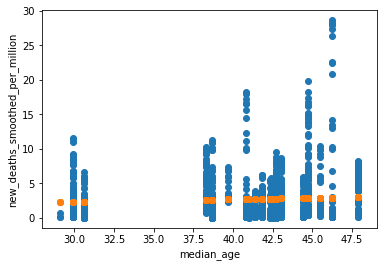

Features: **extreme_poverty**
1. r2_score is 0.020024889830333126
2. adjusted_r2_score is 0.011301075793214377

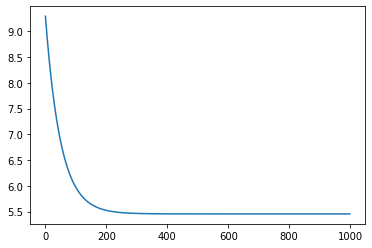

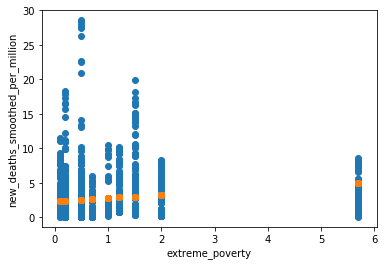

Features: **people_fully_vaccinated_per_hundred**
1. r2_score is 0.17916576746663748
2. adjusted_r2_score is 0.1718586378001684

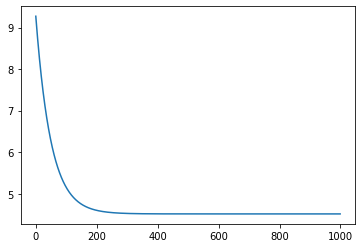

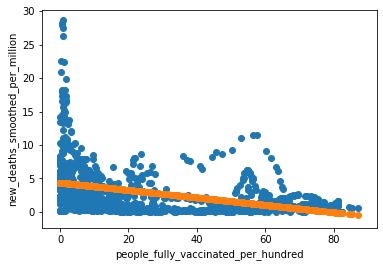

Features: **people_vaccinated_per_hundred**
1. r2_score is 0.2257109391683364
2. adjusted_r2_score is 0.21881815821137796

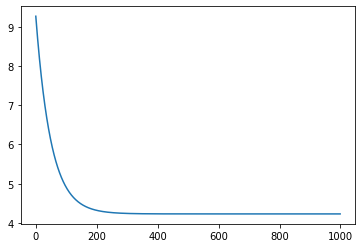

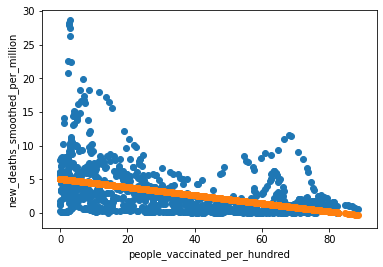

Features: **reproduction_rate**
1. r2_score is 0.04448199021801924
2. adjusted_r2_score is 0.035975895175449746

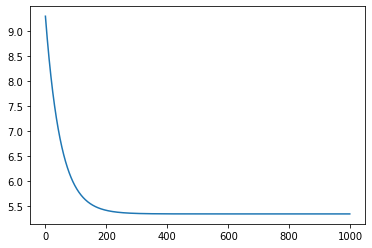

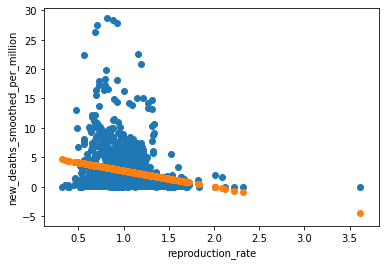

Features: **human_development_index**
1. r2_score is 0.06813995336217726
2. adjusted_r2_score is 0.0598444633327605

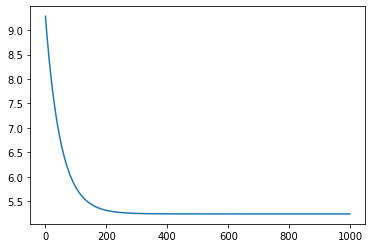

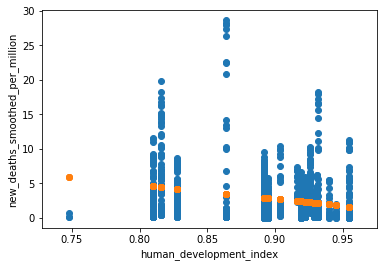

In [5]:
independent_var = ["icu_patients_per_million", "new_cases_smoothed_per_million", "stringency_index", "median_age", "extreme_poverty", "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "reproduction_rate", "human_development_index"]
for i, feature in enumerate(independent_var):
    _, r2, adjusted_r2 = lin_reg(df_dropna_one, [feature], random_state=100)

    

# Multivariate variable selection <a id="multivariate-selection-1"></a>

Next, we fine-tuned the variables selected based on the following reasons:

## 1. High linear correlation
We selected the top 3 independent variables based on their `adjusted_r2_score`.

## 2. Eliminate multicollinearity
[Source](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)

Multicollinearity occurs when the independent variables selected are highly correlated with one another. This means that the change in one independent variables results in the change of another, leading to the model fluctuating significantly. Consequently,
1. Finding optimal beta values may be unstable
2. Overfitting may occur
3. Selection of independent variables may be unpredictable

To prevent multicollinearity, we will be dropping independent variables with high linear correlation with each other. Numerical calculations showcasing the high linear correlation between our independent variables may be found [in the Appendix](#heatmap-1). Also, for the sake of optimising our multivariate linear regression model, we have chosen to drop the variable with a lower linear correlation with our dependent variable. Hence, the following variables will be dropped:
1. `new_cases_smoothed_per_million` - Strong linear correlation with `icu_patients_per_million`
2. `people_fully_vaccinated_per_hundred` - Strong linear correlation with `people_vaccinated_per_hundred`


## 3. Removing variables with negligible linear correlation

Similar to 1, we removed variables which [showed](#univariate-1) a linear correlation of < 0.01 with our independent variable.

[Back To Top](#contents)

# Multivariate Linear Regression <a id="multivariate-high-1"></a>

To prevent overfitting, we will only be concerned with the `adjusted_r2_score`. For reference, the highest `adjusted_r2_score` through univariate linear regression is 0.592940113924265. Highest value is in **bold**.

|                                                                           |       r2 |   adjusted_r2 |
|:--------------------------------------------------------------------------|---------:|--------------:|
| icu_patients_per_million, people_vaccinated_per_hundred                   | 0.60807  |      0.602813 |
| icu_patients_per_million, people_vaccinated_per_hundred, stringency_index | 0.608751 |      **0.603504** |

## Analysis
While multivariate linear regression did showed an improvement in the `adjusted_r2_score`, **the improvement is arguably slight**.

[Back To Top](#contents)

Features: **icu_patients_per_million, people_vaccinated_per_hundred**
1. r2_score is 0.6080696126819294
2. adjusted_r2_score is 0.6045806181360712

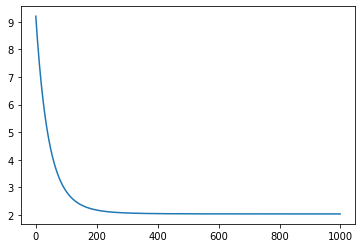

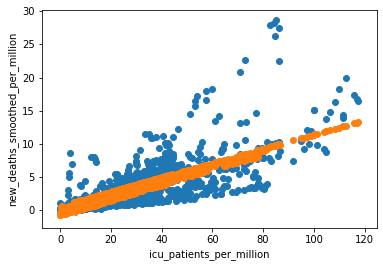

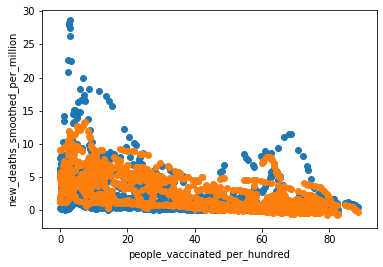

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index**
1. r2_score is 0.6087513220054519
2. adjusted_r2_score is 0.6052683960885865

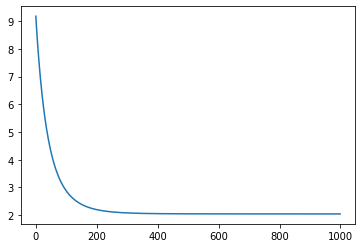

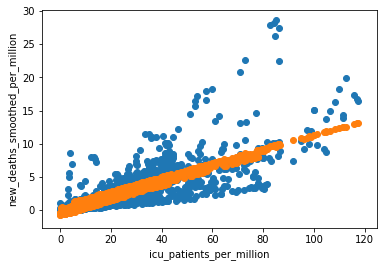

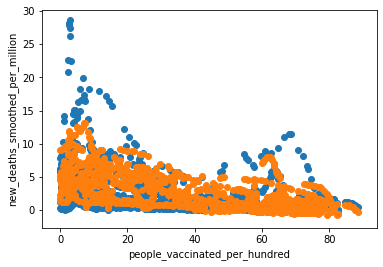

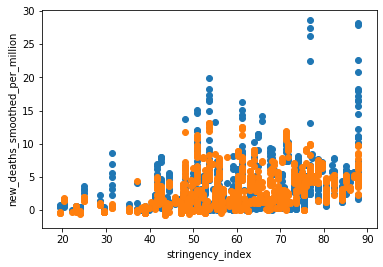

In [6]:
table = [["", "r2", "adjusted_r2"]]

top_two_features = ["icu_patients_per_million", "people_vaccinated_per_hundred"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_two_features, random_state=100)

table.append([", ".join(top_two_features), r2, adjusted_r2])

top_three_features = ["icu_patients_per_million", "people_vaccinated_per_hundred", "stringency_index"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_features, random_state=100)

table.append( [", ".join(top_three_features), r2, adjusted_r2])



# What happens if we only have variables with low linear correlation? <a id="multivariate-low-1"></a>
For reference, the highest `adjusted_r2_score` amongst the 4 variables listed below, for univariate linear regression, is 0.00835851947117039. Highest value obtained through multivariate linear regression is given in **bold**.

|                                                                         |        r2 |   adjusted_r2 |
|:------------------------------------------------------------------------|----------:|--------------:|
| median_age, extreme_poverty                                             | 0.0205068 |    0.00736906 |
| median_age, extreme_poverty, reproduction_rate                          | 0.0634354 |    0.0508734  |
| median_age, extreme_poverty, reproduction_rate, human_development_index | 0.113784  |    **0.101898**   |

## Analysis
As expected, while we do see an increase in overall `adjusted_r2_score`, the new `adjusted_r2_score` is still low.

[Back To Top](#contents)

Features: **median_age, extreme_poverty**
1. r2_score is 0.020506817566091406
2. adjusted_r2_score is 0.011787293686857825

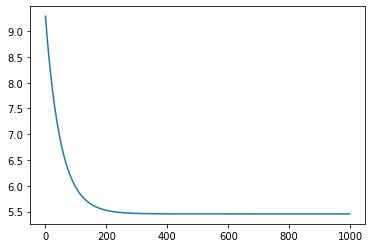

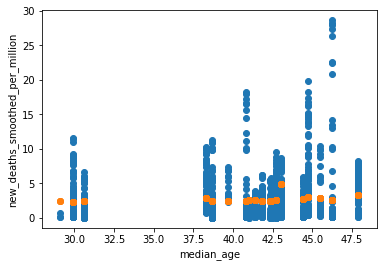

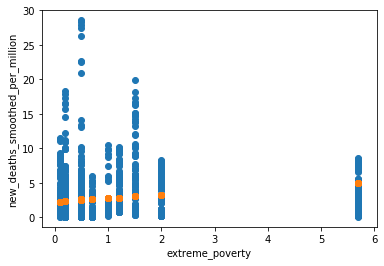

Features: **median_age, extreme_poverty, reproduction_rate**
1. r2_score is 0.06343537009193767
2. adjusted_r2_score is 0.05509799949928429

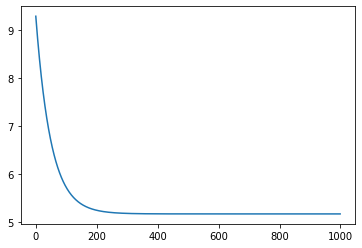

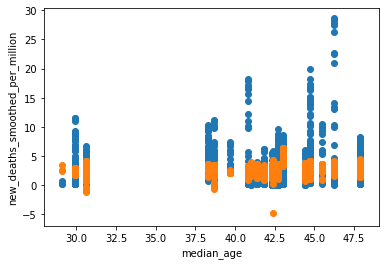

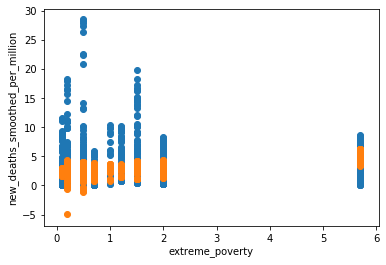

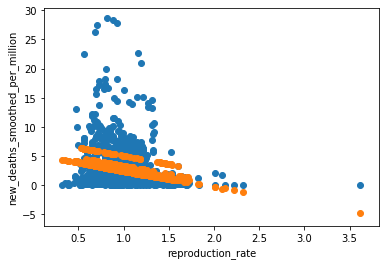

Features: **median_age, extreme_poverty, reproduction_rate, human_development_index**
1. r2_score is 0.11378428257773465
2. adjusted_r2_score is 0.10589512188851558

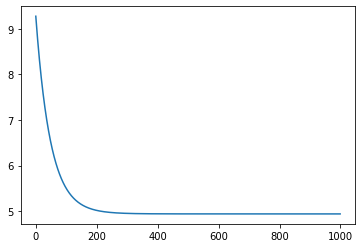

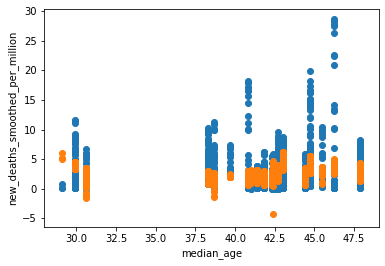

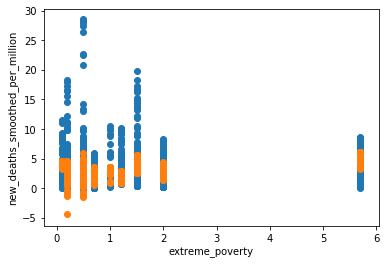

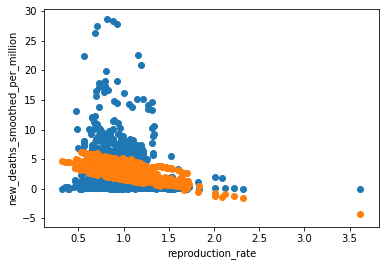

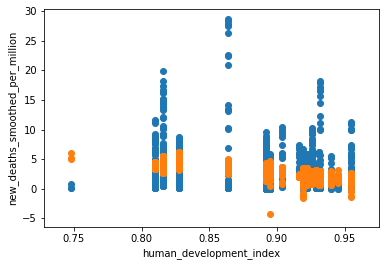

In [7]:
table = [["", "r2", "adjusted_r2"]]

bottom_two_features = ["median_age", "extreme_poverty"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, bottom_two_features, random_state=100)

table.append([", ".join(bottom_two_features), r2, adjusted_r2])

bottom_three_features = ["median_age", "extreme_poverty", "reproduction_rate"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, bottom_three_features, random_state=100)

table.append([", ".join(bottom_three_features), r2, adjusted_r2])

bottom_four_features = ["median_age", "extreme_poverty", "reproduction_rate", "human_development_index"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, bottom_four_features, random_state=100)

table.append([", ".join(bottom_four_features), r2, adjusted_r2])


# Combining variables with high & low linear correlation <a id="multivariate-high-low-1"></a>
For experimental purposes, we developed a multivariate linear regression model using independent variables with both high and low linear correlation. Highest value obtained is given in **bold**. For reference, the highest `adjusted_r2_score` we have obtained thus far, from a combination of the top three features, is 0.6058531836499368.

|                                                                                                                                                    |       r2 |   adjusted_r2 |
|:---------------------------------------------------------------------------------------------------------------------------------------------------|---------:|--------------:|
| icu_patients_per_million, median_age                                                                                                               | 0.59587  |      0.59045  |
| Top 2 + Bottom 2 features  | 0.60694  |      0.601668 |
| All 7 features | 0.615201 |      **0.610039** |

## Analysis
The `adjusted_r2_score` of all 7 features trumped that of the top 3 features by only 0.007. In other words, our multivariate linear regression model using just the top three features is **just as good** as combining all seven features. **Since the model with 3 features is far less computationally intensive, it should still be preferentially selected**.

[Back To Top](#contents)

Features: **icu_patients_per_million, median_age**
1. r2_score is 0.5958700863848244
2. adjusted_r2_score is 0.5922724907146597

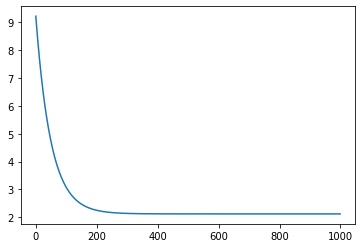

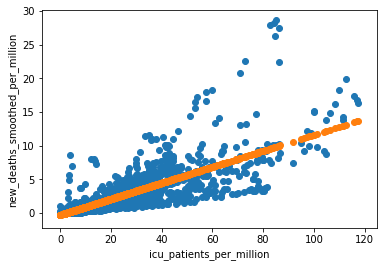

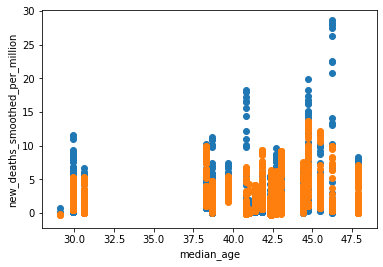

Features: **icu_patients_per_million, people_vaccinated_per_hundred, median_age, extreme_poverty**
1. r2_score is 0.6069398578564481
2. adjusted_r2_score is 0.6034408061459713

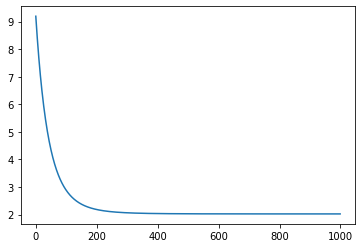

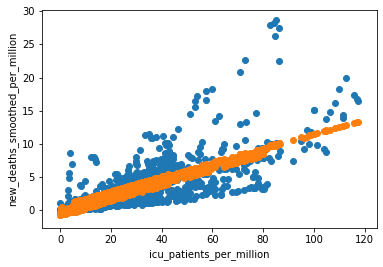

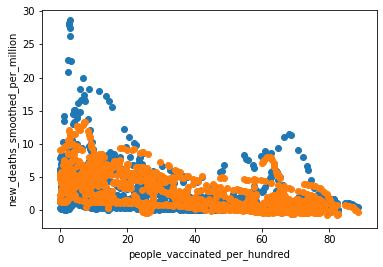

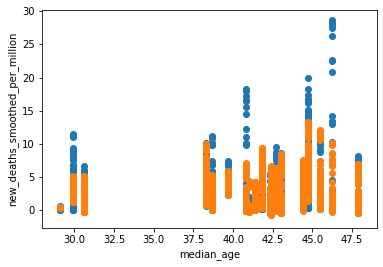

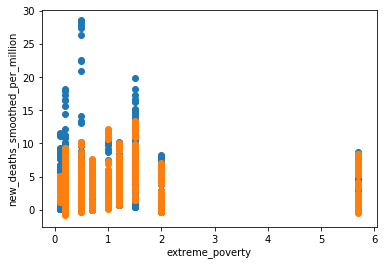

Features: **icu_patients_per_million, stringency_index, median_age, extreme_poverty, people_vaccinated_per_hundred, reproduction_rate, human_development_index**
1. r2_score is 0.615200713926279
2. adjusted_r2_score is 0.611775200993872

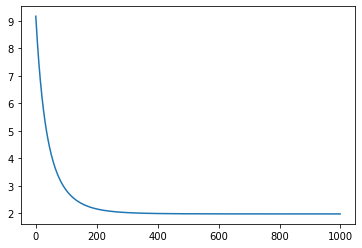

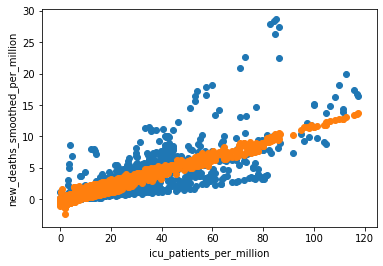

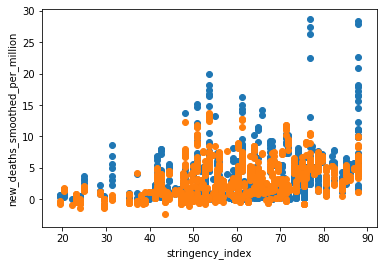

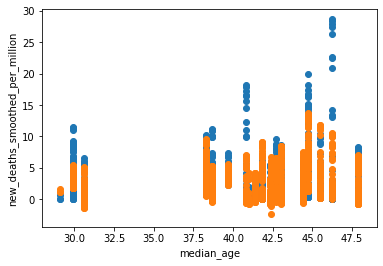

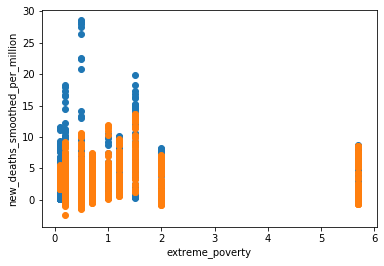

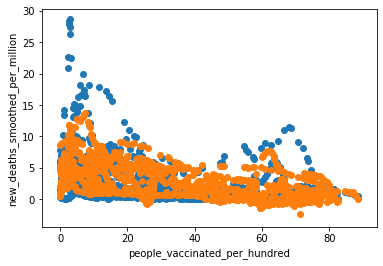

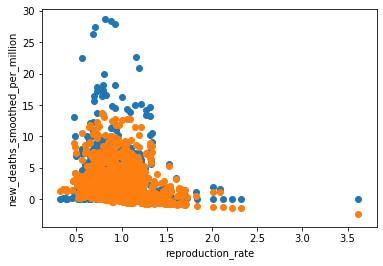

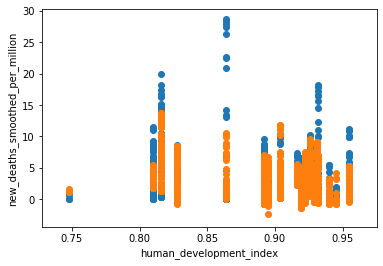

In [8]:
table = [["", "r2", "adjusted_r2"]]

top_and_bottom_features = ["icu_patients_per_million", "median_age"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_and_bottom_features, random_state=100)
table.append([", ".join(top_and_bottom_features), r2, adjusted_r2])


top_two_and_bottom_two_features = ["icu_patients_per_million", "people_vaccinated_per_hundred", "median_age", "extreme_poverty"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_two_and_bottom_two_features, random_state=100)
table.append([", ".join(top_two_and_bottom_two_features), r2, adjusted_r2])


all_seven_features = ["icu_patients_per_million", "stringency_index", "median_age", "extreme_poverty", "people_vaccinated_per_hundred", "reproduction_rate", "human_development_index"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, all_seven_features, random_state=100)
table.append([", ".join(all_seven_features), r2, adjusted_r2])


# Feature transformation <a id="transformation-1"></a>

In a bid to further improve our multivariate linear regression model, we attempted to square root and square our top three independent variables. For reference, the highest `adjusted_r2_score` we have obtained thus far, from a combination of the top three features, is 0.6058531836499368. Models which performed better have their `adjusted_r2_score` highlighted in **bold**

|                                                                                                                      |       r2 |   adjusted_r2 |
|:---------------------------------------------------------------------------------------------------------------------|---------:|--------------:|
| With icu_patients_per_million_squared          | 0.618999 |      **0.613889** |
| With icu_patients_per_million_square_root      | 0.598616 |      0.593232 |
| With people_vaccinated_per_hundred_squared     | 0.61373  |      **0.60855**  |
| With people_vaccinated_per_hundred_square_root | 0.615667 |      **0.610512** |
| With stringency_index_squared                  | 0.614383 |      **0.609211** |
| With stringency_index_square_root              | 0.609623 |      0.604387 |

[Back To Top](#contents)

In [9]:
df_dropna_one["icu_patients_per_million_squared"] = df_dropna_one["icu_patients_per_million"] ** 2
df_dropna_one["icu_patients_per_million_square_root"] = np.sqrt(df_dropna_one["icu_patients_per_million"])

df_dropna_one["people_vaccinated_per_hundred_squared"] = df_dropna_one["people_vaccinated_per_hundred"] ** 2
df_dropna_one["people_vaccinated_per_hundred_square_root"] = np.sqrt(df_dropna_one["people_vaccinated_per_hundred"])

df_dropna_one["stringency_index_squared"] = df_dropna_one["stringency_index"] ** 2
df_dropna_one["stringency_index_square_root"] = np.sqrt(df_dropna_one["stringency_index"])

/Users/Sean/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sean/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Sean/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, icu_patients_per_million_squared**
1. r2_score is 0.6189990734542092
2. adjusted_r2_score is 0.6138887778671569

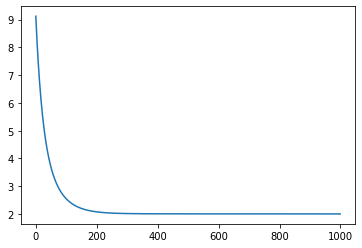

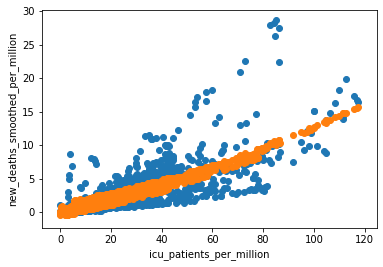

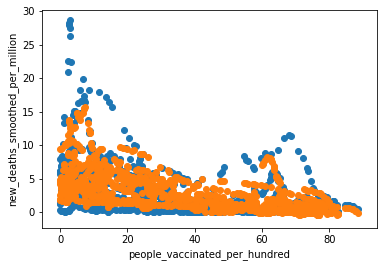

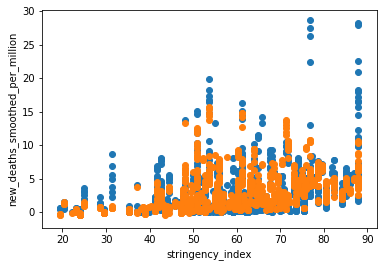

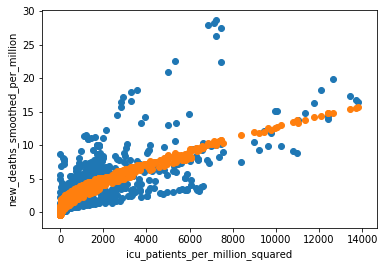

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, icu_patients_per_million_square_root**
1. r2_score is 0.5986161134407233
2. adjusted_r2_score is 0.5932324249473798

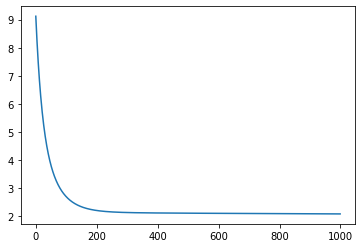

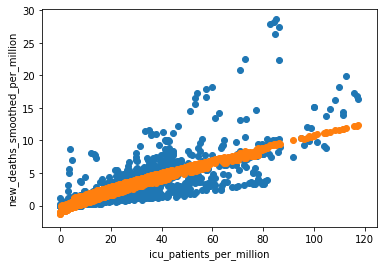

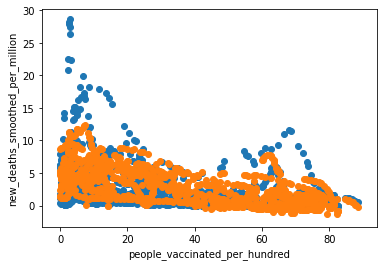

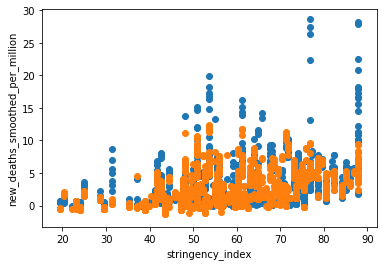

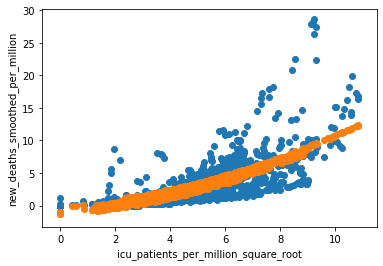

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, people_vaccinated_per_hundred_squared**
1. r2_score is 0.6137304829084251
2. adjusted_r2_score is 0.6085495206821596

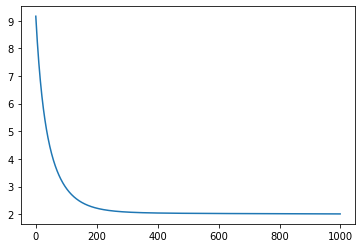

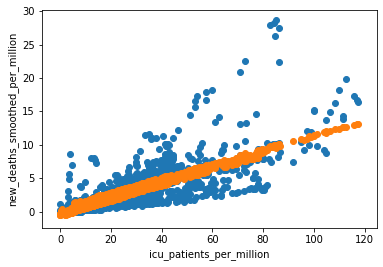

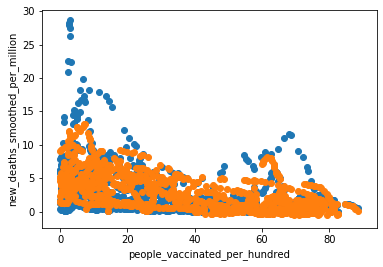

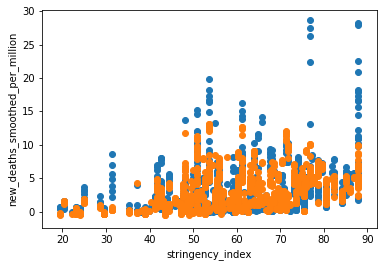

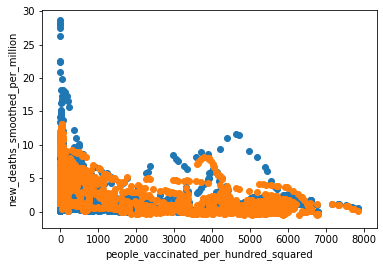

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, people_vaccinated_per_hundred_square_root**
1. r2_score is 0.6156672803100993
2. adjusted_r2_score is 0.610512295992351

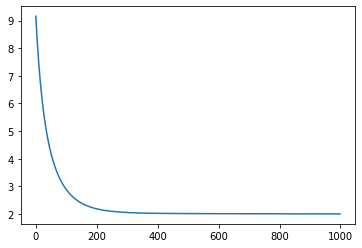

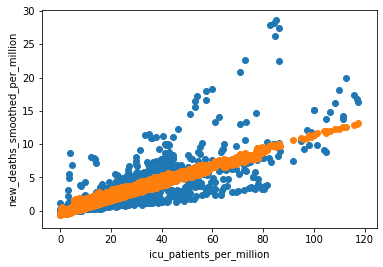

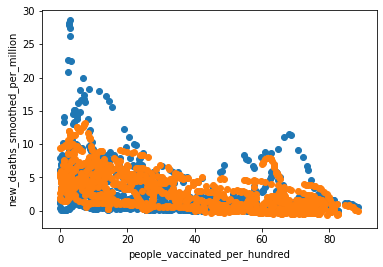

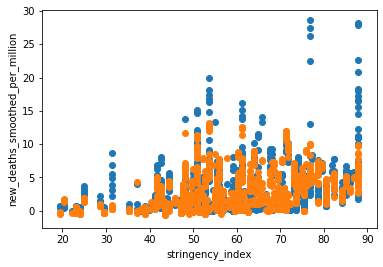

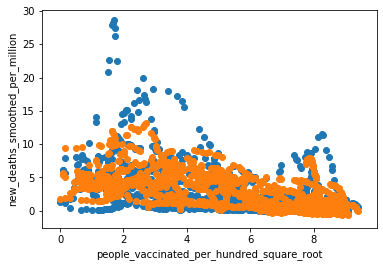

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, stringency_index_squared**
1. r2_score is 0.6143834751597625
2. adjusted_r2_score is 0.6092112713988652

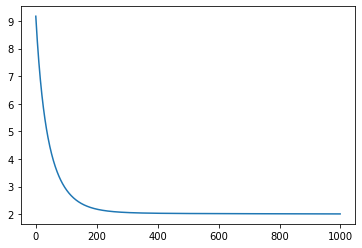

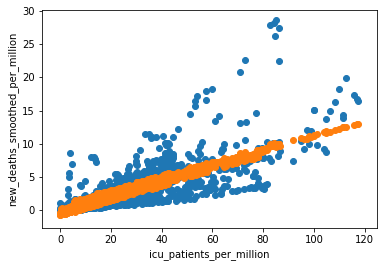

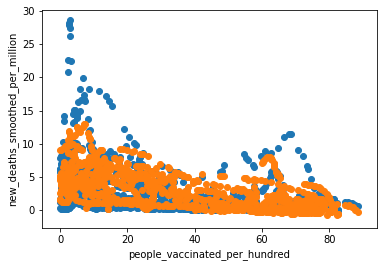

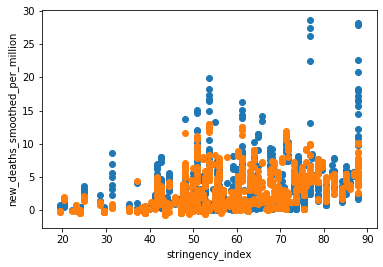

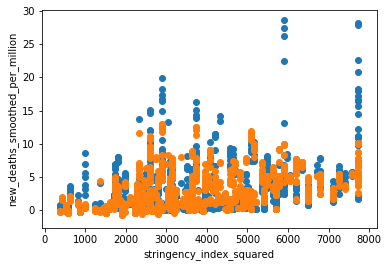

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, stringency_index_square_root**
1. r2_score is 0.6096233768431726
2. adjusted_r2_score is 0.6043873267561213

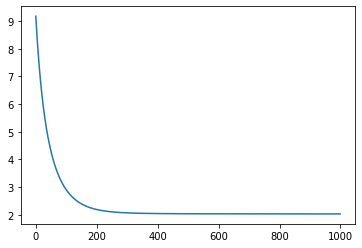

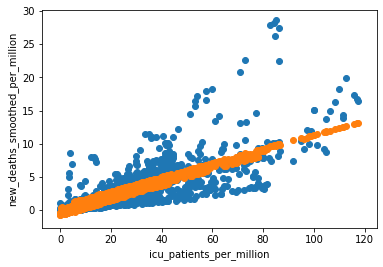

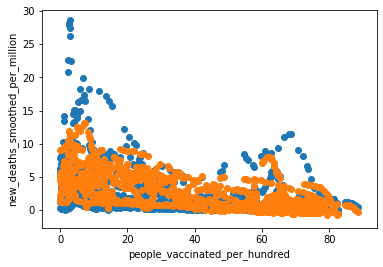

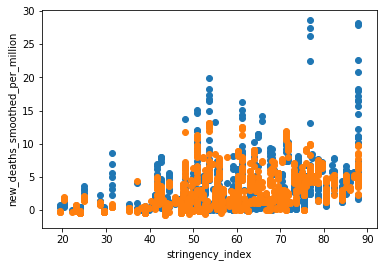

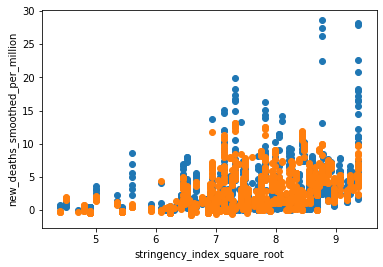

In [10]:
table = [["", "r2", "adjusted_r2"]]

top_three_with_square = top_three_features + ["icu_patients_per_million_squared"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_square, random_state=100,)
table.append([", ".join(top_three_with_square), r2, adjusted_r2])


top_three_with_square_root = top_three_features + ["icu_patients_per_million_square_root"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_square_root, random_state=100,)
table.append([", ".join(top_three_with_square_root), r2, adjusted_r2])


top_three_with_square = top_three_features + ["people_vaccinated_per_hundred_squared"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_square, random_state=100,)
table.append([", ".join(top_three_with_square), r2, adjusted_r2])


top_three_with_square_root = top_three_features + ["people_vaccinated_per_hundred_square_root"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_square_root, random_state=100,)
table.append([", ".join(top_three_with_square_root), r2, adjusted_r2])


top_three_with_square = top_three_features + ["stringency_index_squared"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_square, random_state=100,)
table.append([", ".join(top_three_with_square), r2, adjusted_r2])


top_three_with_square_root = top_three_features + ["stringency_index_square_root"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_square_root, random_state=100)
table.append([", ".join(top_three_with_square_root), r2, adjusted_r2])


# Combining transformed features <a id="combined-1"></a>
From the experimental results obtained, we developed a model by combining the polynomial features which obtained a higher `adjusted_r2_score`. Highest value is indicated in **bold**

|                                                                                                                                                                                                                         |       r2 |   adjusted_r2 |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------:|--------------:|
| With top 2 transformed features                                                                 | 0.626004 |      0.620987 |
| With top 3 transformed features                        | 0.632497 |      0.627568 |
| With top 4 transformed features  | 0.639255 |      **0.634417** |

## Analysis
By introducing transformed features to our model, the `adjusted_r2_score` had a **marked improvement of more than 0.04**.

[Back To Top](#contents)

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, icu_patients_per_million_squared, people_vaccinated_per_hundred_square_root**
1. r2_score is 0.6260035458604825
2. adjusted_r2_score is 0.6209871999778362

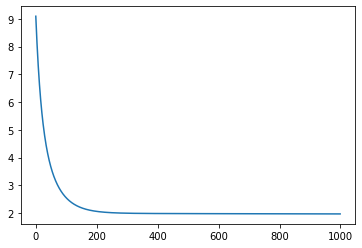

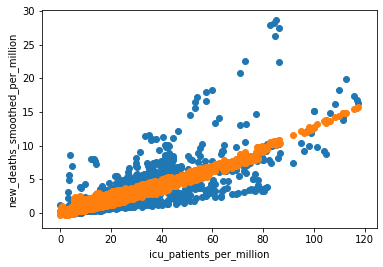

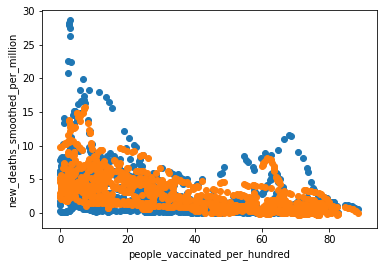

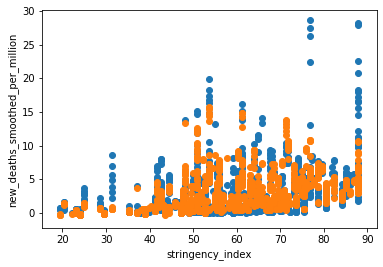

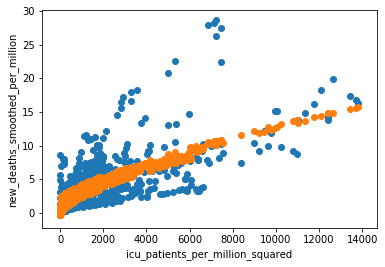

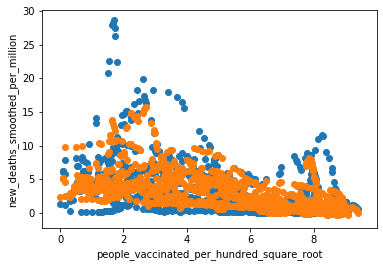

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, icu_patients_per_million_squared, people_vaccinated_per_hundred_square_root, people_vaccinated_per_hundred_squared**
1. r2_score is 0.6324973765179638
2. adjusted_r2_score is 0.6275681311955519

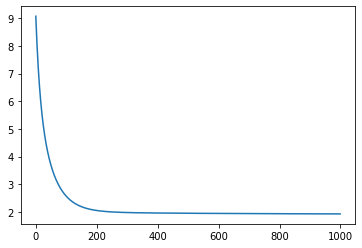

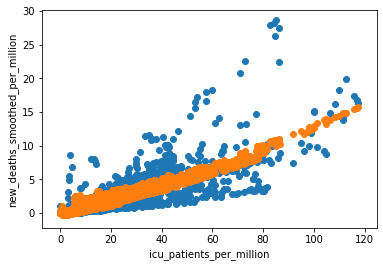

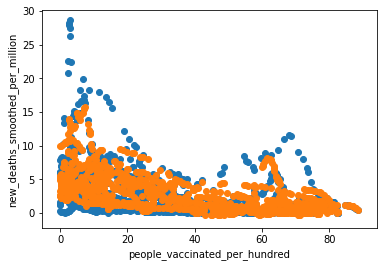

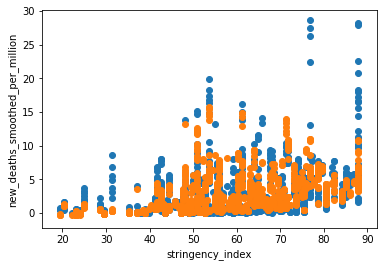

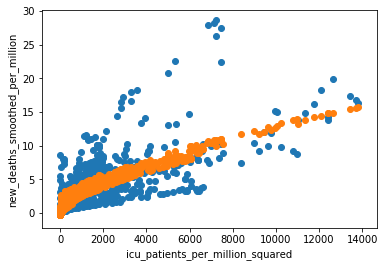

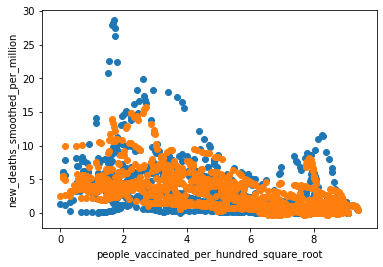

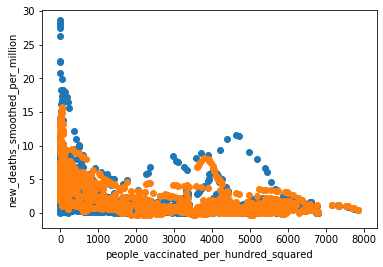

Features: **icu_patients_per_million, people_vaccinated_per_hundred, stringency_index, icu_patients_per_million_squared, people_vaccinated_per_hundred_square_root, people_vaccinated_per_hundred_squared, stringency_index_squared**
1. r2_score is 0.6392551694095301
2. adjusted_r2_score is 0.634416565124412

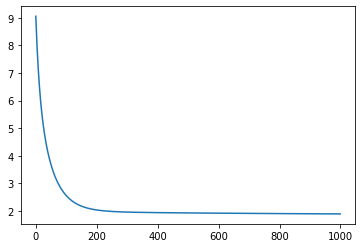

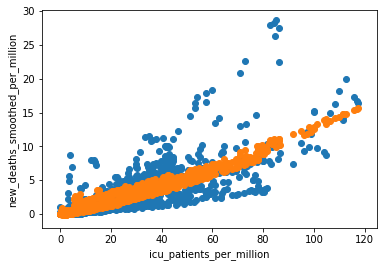

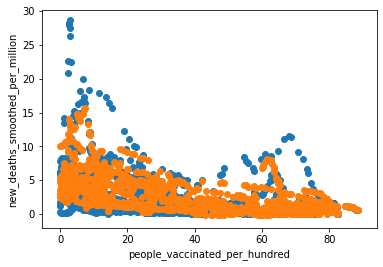

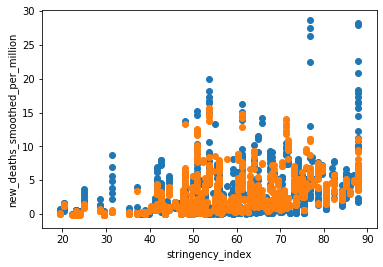

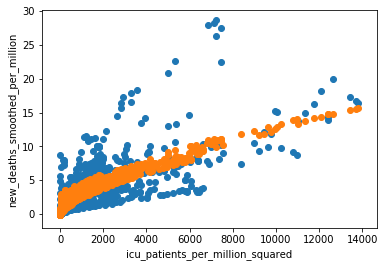

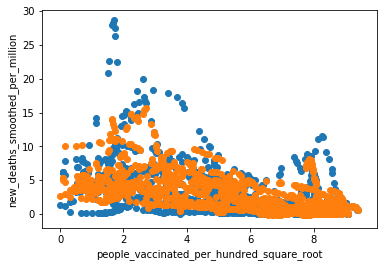

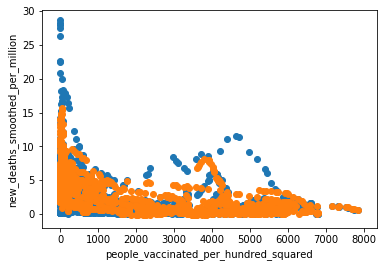

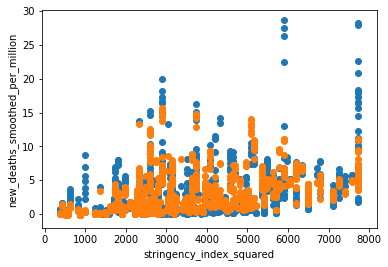

In [11]:
table = [["", "r2", "adjusted_r2"]]

top_three_with_top_two_transformed = top_three_features + ["icu_patients_per_million_squared", "people_vaccinated_per_hundred_square_root"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_top_two_transformed)
table.append([", ".join(top_three_with_top_two_transformed), r2, adjusted_r2])

top_three_with_top_three_transformed = top_three_features + ["icu_patients_per_million_squared", "people_vaccinated_per_hundred_square_root", "people_vaccinated_per_hundred_squared"]
_, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_top_three_transformed)
table.append([", ".join(top_three_with_top_three_transformed), r2, adjusted_r2])

top_three_with_top_four_transformed = top_three_features + ["icu_patients_per_million_squared", "people_vaccinated_per_hundred_square_root", "people_vaccinated_per_hundred_squared", "stringency_index_squared"]
beta, r2, adjusted_r2 = lin_reg(df_dropna_one, top_three_with_top_four_transformed)
table.append([", ".join(top_three_with_top_four_transformed), r2, adjusted_r2])


# Conclusion <a id="summary-1"></a>


## Final model

Our team attempted to predict daily deaths due to COVID-19 based on historical data. Independent of time and location, our final model is able to achieve a relatively high linear correlation of 0.634417. This model is ~0.04 higher than a simple linear correlation model (Highest value obtained was 0.592940113924265) and it consists of the following independent variables:
1. `icu_patients_per_million` 
2. `people_vaccinated_per_hundred`
3. `stringency_index`
4. `icu_patients_per_million_squared`
5. `people_vaccinated_per_hundred_square_root`
6. `people_vaccinated_per_hundred_squared`
7. `stringency_index_squared`

## Analysis

These findings show strong justifications that vaccinations may indeed help to curb death rates due to COVID-19. Additionally, it may also prove that implementing safe management measures in response to COVID-19 helps to curb death rates due to COVID-19. Most trivially, our results show that having a higher number of ICU patients leads to a higher death rate, which likely tells us that patients within the ICU are more likely to die as a result of COVID-19.

All that being said, we are aware that correlation does not equate to causation. Hence, further experiments need to be conducted to justify the hypotheses laid out above.

However, regardless of whether our hypotheses are true, we have developed a sufficiently accurate linear regression model to predict death rates due to COVID-19, at least until 10th November 2021.

## Future work

To further test the strength of our model, our model should be tested against future datasets. If the linear regression remains high of > 0.5, it shows that our model is indeed independent of time and is not overfitting the data.

Additionally, our model has the potential to be further improved by introducing non-linear models, introducing other features that we were unable to test due to dataset and time limitations or by further transforming our current features.

Finally, our model can be improved by choosing a data set with a lower proportion of rows with missing values.

[Back To Top](#contents)

# Task 1 Text Only <a id="text-only-1"></a>

## Variable Selection & Definitions
To predict `new_deaths_smoothed_per_million`, we experimented with the following independent variables. These variables were initially chosen through intellectual conjecture on what variables are most likely to affect `new_deaths_smoothed_per_million`. Subsequently, we elaborated on the steps taken to ensure we picked variables that were the most linearly related to `new_deaths_smoothed_per_million`.

### Independent Variables
1. `icu_patients_per_million` = Number of COVID-19 patients in intensive care units (ICUs) on a given day per 1,000,000 people
2. `new_cases_smoothed_per_million` = New confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people
3. `stringency_index` = Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)
4. `median_age` = Median age of the population, UN projection for 2020
5. `extreme_poverty` = Share of the population living in extreme poverty, most recent year available since 2010
6. `people_fully_vaccinated_per_hundred` = Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population
7. `people_vaccinated_per_hundred` = Total number of people who received at least one vaccine dose per 100 people in the total population
8. `reproduction_rate` = Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database
9. `human_development_index` = A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506

### Dependent Variable
1. `new_deaths_smoothed_per_million` = New deaths attributed to COVID-19 (7-day smoothed) per 1,000,000 people

## Data pre-processing 

### Attempt 1 - Forward fill
We attempted to replace missing values using both the forward fill and backward fill techniques. However, this resulted in a much poorer linear correlation between our independent and dependent variables. [See our Appendix for the numerical calculations](#replace-1).


### Attempt 2 - Dropping missing values
As > 95% of the data points contain rows that have missing values, we decided to drop the rows with missing values altogether as filling them up through either forward or backward propagation would inevitably skew the data points towards a more unnatural result. This also produced a more favourable linear correlation between our independent and dependent variables which will be shown in our next section.

We processed the data by 
1. Extracting out columns containing our independent and dependent variables
2. Dropping rows with missing values


## Univariate Linear Regression

For reliability purposes, a random_state of 100 has been set. `r2` and `adjusted_r2` values have been sorted in ascending order.

|                                       |         r2 |   adjusted_r2 |
|:--------------------------------------|-----------:|--------------:|
| `icu_patients_per_million`            | 0.595933   |    0.590514   |
| `new_cases_smoothed_per_million`      | 0.277922   |    0.268237   |
| `stringency_index`                    | 0.116847   |    0.105001   |
| `median_age`                          | 0.00456267 |   -0.00878895 |
| `extreme_poverty`                     | 0.0200249  |    0.00688066 |
| `people_fully_vaccinated_per_hundred` | 0.179166   |    0.168156   |
| `people_vaccinated_per_hundred`       | 0.225711   |    0.215326   |
| `reproduction_rate`                   | 0.044482   |    0.0316658  |
| `human_development_index`             | 0.06814    |    0.0556411  |

### Analysis
Only the number of ICU patients per million had a significant linear correlation with respect to the number of new deaths per million (Smoothed across 7 days).

Vaccination rates, new cases per million (Smoothed across 7 days) and stringency index produced a relatively moderate linear correlation, indicating a moderate degree of correlation between the two variables.

## Multivariate variable selection

Next, we fine-tuned the variables selected based on the following reasons:

### 1. High linear correlation
We selected the top 3 independent variables based on their `adjusted_r2_score`.

### 2. Eliminate multicollinearity
[Source](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)

Multicollinearity occurs when the independent variables selected are highly correlated with one another. This means that the change in one independent variables results in the change of another, leading to the model fluctuating significantly. Consequently,
1. Finding optimal beta values may be unstable
2. Overfitting may occur
3. Selection of independent variables may be unpredictable

To prevent multicollinearity, we will be dropping independent variables with high linear correlation with each other. Numerical calculations showcasing the high linear correlation between our independent variables may be found [in the Appendix](#heatmap-1). Also, for the sake of optimising our multivariate linear regression model, we have chosen to drop the variable with a lower linear correlation with our dependent variable. Hence, the following variables will be dropped:
1. `new_cases_smoothed_per_million` - Strong linear correlation with `icu_patients_per_million`
2. `people_fully_vaccinated_per_hundred` - Strong linear correlation with `people_vaccinated_per_hundred`


### 3. Removing variables with negligible linear correlation

Similar to 1, we removed variables which [showed](#univariate-1) a linear correlation of < 0.01 with our independent variable.

## Multivariate Linear Regression

To prevent overfitting, we will only be concerned with the `adjusted_r2_score`. For reference, the highest `adjusted_r2_score` through univariate linear regression is 0.592940113924265. Highest value is in **bold**.

|                                                                           |       r2 |   adjusted_r2 |
|:--------------------------------------------------------------------------|---------:|--------------:|
| icu_patients_per_million, people_vaccinated_per_hundred                   | 0.60807  |      0.602813 |
| icu_patients_per_million, people_vaccinated_per_hundred, stringency_index | 0.608751 |      **0.603504** |

### Analysis
While multivariate linear regression did showed an improvement in the `adjusted_r2_score`, **the improvement is arguably slight**.


## What happens if we only have variables with low linear correlation?
For reference, the highest `adjusted_r2_score` amongst the 4 variables listed below, for univariate linear regression, is 0.00835851947117039. Highest value obtained through multivariate linear regression is given in **bold**.

|                                                                         |        r2 |   adjusted_r2 |
|:------------------------------------------------------------------------|----------:|--------------:|
| median_age, extreme_poverty                                             | 0.0205068 |    0.00736906 |
| median_age, extreme_poverty, reproduction_rate                          | 0.0634354 |    0.0508734  |
| median_age, extreme_poverty, reproduction_rate, human_development_index | 0.113784  |    **0.101898**   |

### Analysis
As expected, while we do see an increase in overall `adjusted_r2_score`, the new `adjusted_r2_score` is still low.

## Combining variables with high & low linear correlation
For experimental purposes, we developed a multivariate linear regression model using independent variables with both high and low linear correlation. Highest value obtained is given in **bold**. For reference, the highest `adjusted_r2_score` we have obtained thus far, from a combination of the top three features, is 0.6058531836499368.

|                                                                                                                                                    |       r2 |   adjusted_r2 |
|:---------------------------------------------------------------------------------------------------------------------------------------------------|---------:|--------------:|
| icu_patients_per_million, median_age                                                                                                               | 0.59587  |      0.59045  |
| Top 2 + Bottom 2 features  | 0.60694  |      0.601668 |
| All 7 features | 0.615201 |      **0.610039** |


### Analysis
The `adjusted_r2_score` of all 7 features trumped that of the top 3 features by only 0.005. In other words, our multivariate linear regression model using just the top three features is **just as good** as combining all seven features. **Since the model with 3 features is far less computationally intensive, it should still be preferentially selected**.


## Feature transformation

In a bid to further improve our multivariate linear regression model, we attempted to square root and square our top three independent variables. For reference, the highest `adjusted_r2_score` we have obtained thus far, from a combination of the top three features, is 0.6058531836499368. Models which performed better have their `adjusted_r2_score` highlighted in **bold**

|                                                                                                                      |       r2 |   adjusted_r2 |
|:---------------------------------------------------------------------------------------------------------------------|---------:|--------------:|
| With icu_patients_per_million_squared          | 0.618999 |      **0.613889** |
| With icu_patients_per_million_square_root      | 0.598616 |      0.593232 |
| With people_vaccinated_per_hundred_squared     | 0.61373  |      **0.60855**  |
| With people_vaccinated_per_hundred_square_root | 0.615667 |      **0.610512** |
| With stringency_index_squared                  | 0.614383 |      **0.609211** |
| With stringency_index_square_root              | 0.609623 |      0.604387 |


## Combining transformed features
From the experimental results obtained, we developed a model by combining the polynomial features which obtained a higher `adjusted_r2_score`. Highest value is indicated in **bold**

|                                                                                                                                                                                                                         |       r2 |   adjusted_r2 |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------:|--------------:|
| With top 2 transformed features                                                                 | 0.626004 |      0.620987 |
| With top 3 transformed features                        | 0.632497 |      0.627568 |
| With top 4 transformed features  | 0.639255 |      **0.634417** |


## Analysis
By introducing transformed features to our model, the `adjusted_r2_score` had a **marked improvement of more than 0.04**.


# Conclusion

## Final model

Our team attempted to predict daily deaths due to COVID-19 based on historical data. Independent of time and location, our final model is able to achieve a relatively high linear correlation of 0.6521598639422896. This model is ~0.06 higher than a simple linear correlation model (Highest value obtained was 0.592940113924265) and it consists of the following independent variables:
1. `icu_patients_per_million` 
2. `people_vaccinated_per_hundred`
3. `stringency_index`
4. `icu_patients_per_million_squared`
5. `people_vaccinated_per_hundred_square_root`
6. `people_vaccinated_per_hundred_squared`
7. `stringency_index_squared`

## Analysis

These findings show strong justifications that vaccinations may indeed help to curb death rates due to COVID-19. Additionally, it may also prove that implementing safe management measures in response to COVID-19 helps to curb death rates due to COVID-19. Most trivially, our results show that having a higher number of ICU patients leads to a higher death rate, which likely tells us that patients within the ICU are more likely to die as a result of COVID-19.

All that being said, we are aware that correlation does not equate to causation. Hence, further experiments need to be conducted to justify the hypotheses laid out above.

However, regardless of whether our hypotheses are true, we have developed a sufficiently accurate linear regression model to predict death rates due to COVID-19, at least until 10th November 2021.

## Future work

To further test the strength of our model, our model should be tested against future datasets. If the linear regression remains high of > 0.5, it shows that our model is indeed independent of time and is not overfitting the data.

Additionally, our model has the potential to be further improved by introducing non-linear models, introducing other features that we were unable to test due to dataset and time limitations or by further transforming our current features.

Finally, our model can be improved by choosing a data set with a lower proportion of rows with missing values.

[Back To Top](#contents)

# Task 2



# Problem Statement <a id="problem-statement"></a>

## How might we accurately predict the number of COVID-19 patients within hospitals?
1. Do the number of hospital admissions drastically decline due to government's safe management measures?
2. To what extent do increase in vaccination rates help to curb hospital admissions?
3. How linearly related is an increase in COVID-19 cases linked to an increase in hospital admissions? Is this necessarily the same for both developed and less developed countries

[Back To Top](#contents)

# Variable Selection & Definitions <a id='definitions-2'></a>
Due to the problem statement listed above, we will be selecting the following independent and dependent variables.


## Independent Variables

1. `people_vaccinated_per_hundred` = Total number of people who received at least one vaccine dose per 100 people in the total population
2. `people_fully_vaccinated_per_hundred` = Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population
3. `new_cases_smoothed_per_million` = New confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people
4. `new_deaths_smoothed_per_million` = New deaths attributed to COVID-19 (7-day smoothed) per 1,000,000 people
5. `population_density` = Number of people divided by land area, measured in square kilometers, most recent year available
6. `human_development_index` = A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506
7. `stringency_index` = Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)
8. `hospital_beds_per_million` = Hospital beds per 1,000,000 people, most recent year available since 2010

## Dependent Variable
1. `hosp_patients_per_million` = Number of COVID-19 patients in hospital on a given day per 1,000,000 people

[Back To Top](#contents)

# Data pre-processing <a id='data-clean-2'></a>

We processed the data by 
1. Extracting out columns containing our independent and dependent variables
2. Adding the column `hospital_beds_per_million` to our df for ease of visualisation
3. Dropping rows with missing values

[Back To Top](#contents)

In [12]:
useful_cols = ["location", "date", "new_cases_smoothed_per_million", "new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred", "population_density", "human_development_index", "stringency_index", "hospital_beds_per_thousand", "hosp_patients_per_million"]

df_dropna = df[useful_cols]

new_col = df_dropna.loc[:, "hospital_beds_per_thousand"] * 1000

df_dropna.insert(df_dropna.shape[1]-2, "hospital_beds_per_million", new_col)

# Drop rows with nan
df_dropna = df_dropna.dropna()

# Dataset Limitations <a id="limitations-2"></a>

Before we go on, we would like to highlight some inherent limitations in the dataset.

## Lack of data
Countries with `human_development_index < 0.8` do not have any data on their `hosp_patients_per_million`. Hence, we are unable to evaluate to what extent COVID-19 has impacted their healthcare system directly. 

However, since COVID-19 does not discriminate, and countries with low `human_development_index` have lower number of hospital beds per thousand people, it is safe to conclude that the rise in COVID-19 cases amongst countries with lower `human_development_index` would result in a faster plateau / maximum utilisation of hospital beds / collapse of the healthcare system.

[Back To Top](#contents)

In [13]:
df_hdi = df[["hosp_patients_per_million", "hospital_beds_per_thousand", "human_development_index"]]

df_low_hdi = df_hdi[df_hdi.loc[:, "human_development_index"] < 0.8]

# No rows = Insufficient data for countries with hdi < 0.8
df_low_hdi.dropna()

,hosp_patients_per_million,hospital_beds_per_thousand,human_development_index


Text(0, 0.5, 'hospital_beds_per_thousand')

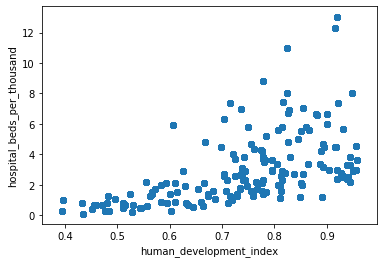

In [14]:
df_low_hdi = df[useful_cols]
df_low_hdi

x_label = "human_development_index"
y_label = "hospital_beds_per_thousand"

# As hdi increases, number of hospital beds per thousand increases
plt.scatter(df_hdi[x_label], df_hdi[y_label])
plt.xlabel(x_label)
plt.ylabel(y_label)

# Univariate Linear Regression <a id="univariate-2"></a>

For reliability purposes, a random_state of 100 has been set. `r2` and `adjusted_r2` values have been sorted in ascending order.

|                                       |        r2 |   adjusted_r2 |
|:--------------------------------------|----------:|--------------:|
| `population_density`                  | 0.0148149 |    0.00883627 |
| `stringency_index`                    | 0.107339  |    0.101922   |
| `hospital_beds_per_million`           | 0.111944  |    0.106554   |
| `people_fully_vaccinated_per_hundred` | 0.185047  |    0.180102   |
| `human_development_index`             | 0.201716  |    0.196872   |
| `people_vaccinated_per_hundred`       | 0.225238  |    0.220536   |
| `new_cases_smoothed_per_million`      | 0.372439  |    0.36863    |
| `new_deaths_smoothed_per_million`     | 0.730197  |    0.728559   |


## Analysis
Only the number of cases per million and number of deaths per million had a significant linear correlation with respect to the number of people hospitalised due to COVID-19. 

Vaccination rates and human development index produced a relatively moderate linear correlation, indicating a moderate degree of correlation between the two variables. From observation alone, we may see that these variables follow an exponential curve instead since the number of patients hospitalised continually decreases more than proportionately with respect to all three variables.

[Back To Top](#contents)

Features: **population_density**
1. r2_score is 0.014814856184494851
2. adjusted_r2_score is 0.009694794804769313

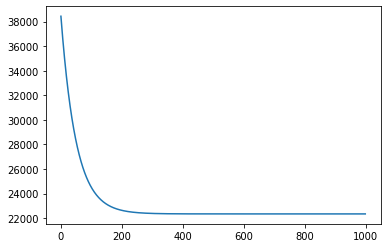

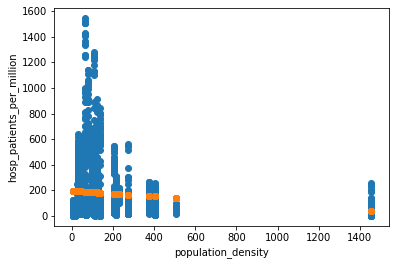

Features: **stringency_index**
1. r2_score is 0.10733907441456658
2. adjusted_r2_score is 0.10269986648601515

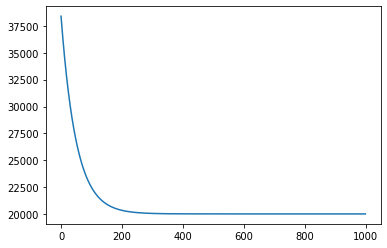

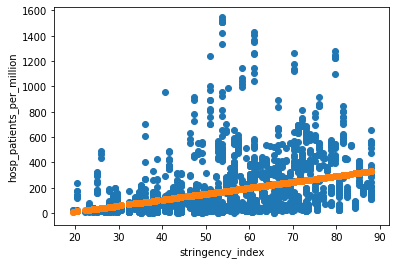

Features: **hospital_beds_per_million**
1. r2_score is 0.11194362294596649
2. adjusted_r2_score is 0.10732834510939282

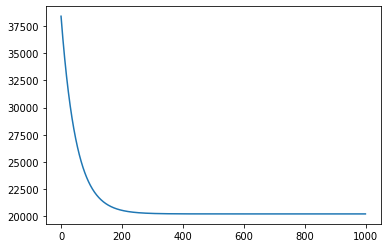

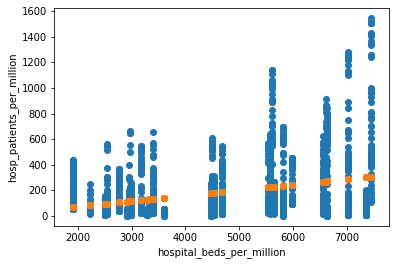

Features: **people_fully_vaccinated_per_hundred**
1. r2_score is 0.1850471027354066
2. adjusted_r2_score is 0.18081174770414843

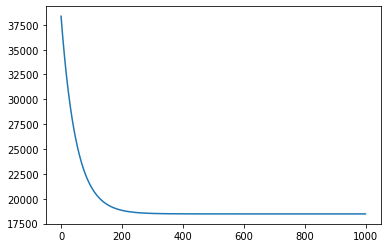

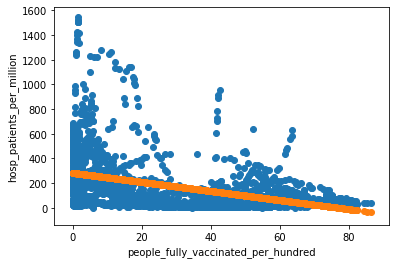

Features: **human_development_index**
1. r2_score is 0.20171604151613753
2. adjusted_r2_score is 0.19756731587655052

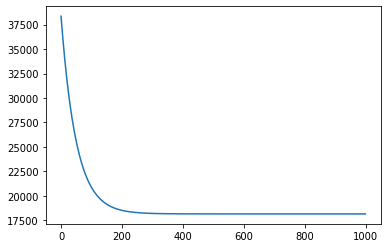

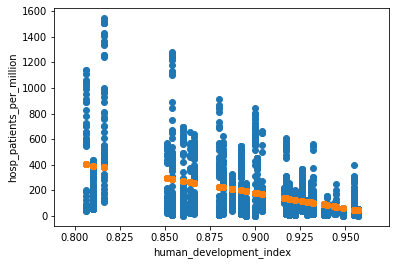

Features: **people_vaccinated_per_hundred**
1. r2_score is 0.22523786759176656
2. adjusted_r2_score is 0.22121138617604597

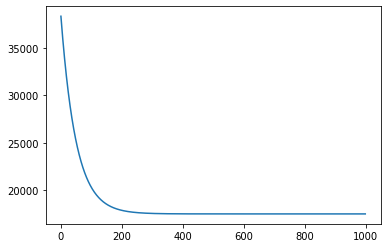

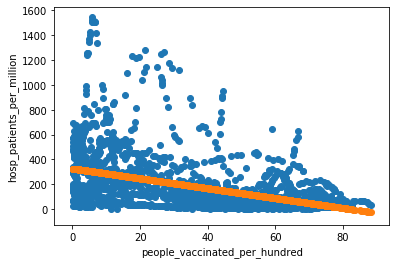

Features: **new_cases_smoothed_per_million**
1. r2_score is 0.37243852894289387
2. adjusted_r2_score is 0.36917705746057017

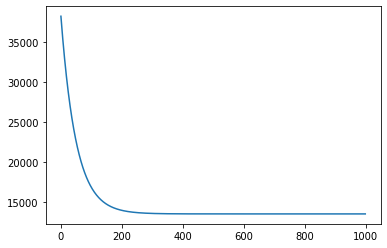

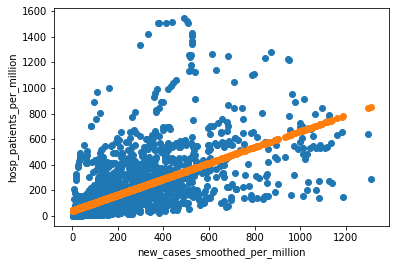

Features: **new_deaths_smoothed_per_million**
1. r2_score is 0.7301966648349734
2. adjusted_r2_score is 0.7287944820623531

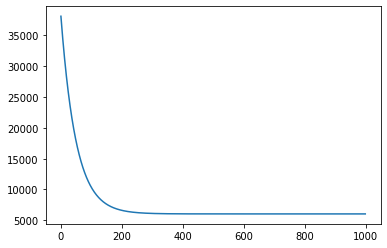

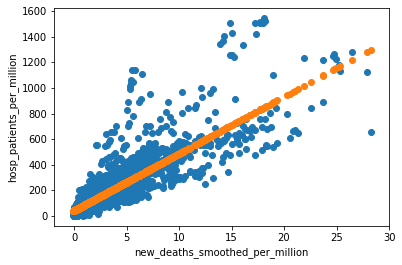

In [15]:
table = [["", "r2", "adjusted_r2"]]

independent_var = ["population_density", "stringency_index", "hospital_beds_per_million", "people_fully_vaccinated_per_hundred", "human_development_index", "people_vaccinated_per_hundred", "new_cases_smoothed_per_million", "new_deaths_smoothed_per_million"]
dep_var = "hosp_patients_per_million"

for feature in independent_var:
    beta, r2, adjusted_r2 = lin_reg(df_dropna, [feature], target_col=[dep_var], random_state=100)
    
    table.append([f"`{feature}`", r2, adjusted_r2])
        

# Multivariate variable selection <a id="multivariate-selection-2"></a>

Next, we fine-tuned the variables selected based on the following reasons:

## 1. High linear correlation
We selected the top 5 independent variables based on their `adjusted_r2_score`.

## 2. Eliminate multicollinearity
[Source](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)

Multicollinearity occurs when the independent variables selected are highly correlated with one another. This means that the change in one independent variables results in the change of another, leading to the model fluctuating significantly. Consequently,
1. Finding optimal beta values may be unstable
2. Overfitting may occur
3. Selection of independent variables may be unpredictable

To prevent multicollinearity, we will be dropping independent variables with high linear correlation with each other. Numerical calculations showcasing the high linear correlation between our independent variables may be found [in the Appendix](#heatmap-2). Also, for the sake of optimising our multivariate linear regression model, we have chosen to drop the variable with a lower linear correlation with our dependent variable. Hence, the following variables will be dropped:
1. `new_cases_smoothed_per_million` - Strong linear correlation with `new_deaths_smoothed_per_million`
2. `people_fully_vaccinated_per_hundred` - Strong linear correlation with `people_vaccinated_per_hundred`


## 3. Removing variables with negligible linear correlation

Similar to 1, we removed variables which [showed](#univariate-2) a linear correlation of < 0.01 with our independent variable.

[Back To Top](#contents)

# Multivariate Linear Regression <a id="multivariate-high-2"></a>

To prevent overfitting, we will only be concerned with the `adjusted_r2_score`. Highest value is in **bold**.


|                |       r2 |   adjusted_r2 |
|:---------------|---------:|--------------:|
| Top 2 features | 0.734358 |      0.732746 |
| Top 3 features | 0.772137 |      0.770754 |
| Top 4 features | 0.774582 |      **0.773214** |
| Top 5 features | 0.774494 |      0.773126 |

[Back To Top](#contents)

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred**
1. r2_score is 0.7343584644331601
2. adjusted_r2_score is 0.7329779107619596

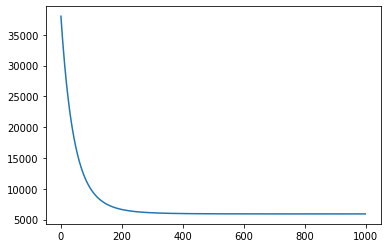

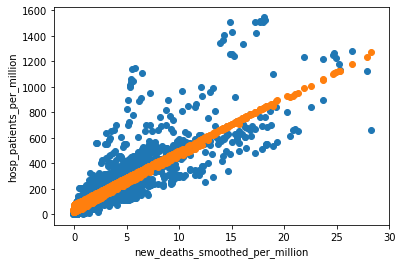

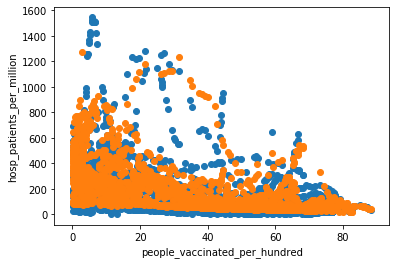

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred, human_development_index**
1. r2_score is 0.7721369168245151
2. adjusted_r2_score is 0.7709526998482892

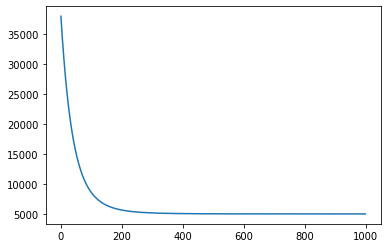

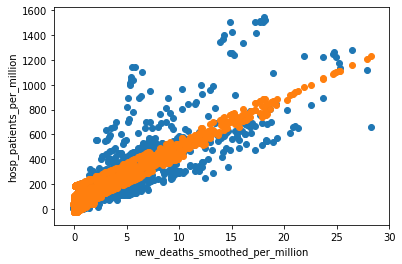

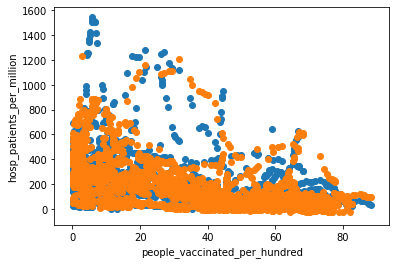

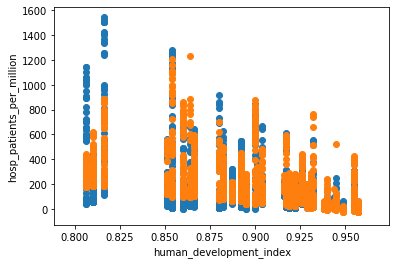

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred, human_development_index, hospital_beds_per_million**
1. r2_score is 0.774582120158874
2. adjusted_r2_score is 0.7734106110388681

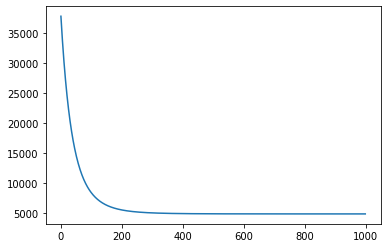

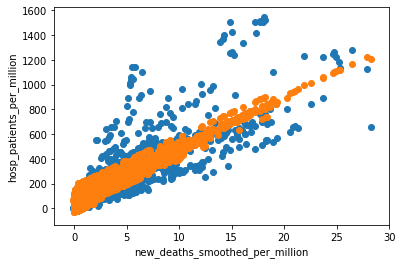

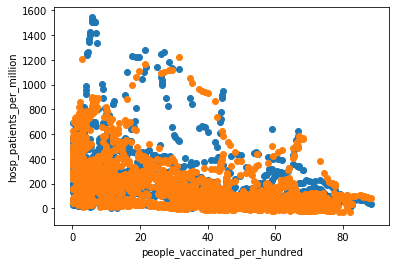

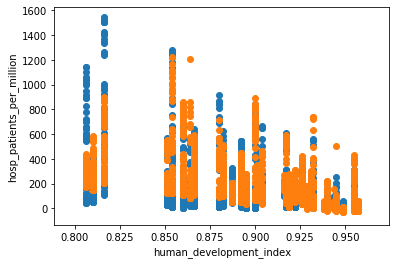

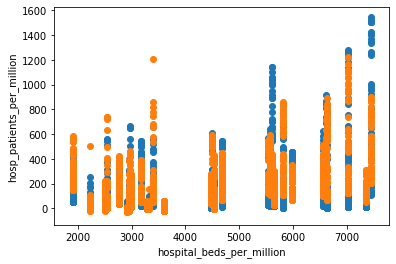

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred, human_development_index, hospital_beds_per_million, stringency_index**
1. r2_score is 0.774494317679361
2. adjusted_r2_score is 0.7733223522450399

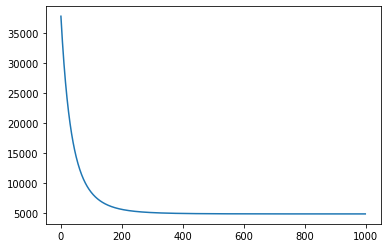

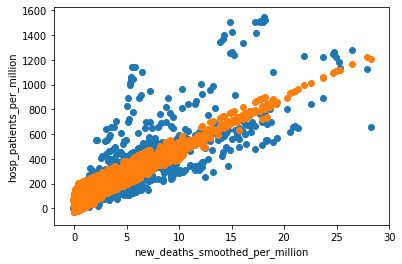

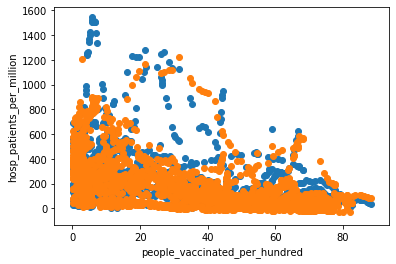

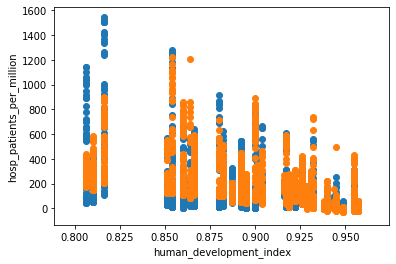

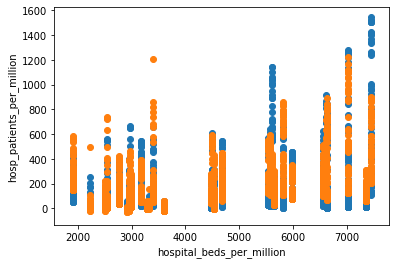

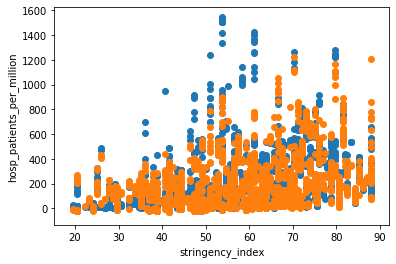

In [16]:
table = [["", "r2", "adjusted_r2"]]

top_two_features = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred"]
beta, r2, adjusted_r2 = lin_reg(df_dropna, top_two_features, target_col=[dep_var], random_state=100)
table.append([f"Top 2 features", r2, adjusted_r2])

top_three_features = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "human_development_index"]
beta, r2, adjusted_r2 = lin_reg(df_dropna, top_three_features, target_col=[dep_var], random_state=100)
table.append([f"Top 3 features", r2, adjusted_r2])

top_four_features = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "human_development_index", "hospital_beds_per_million"]
beta, r2, adjusted_r2 = lin_reg(df_dropna, top_four_features, target_col=[dep_var], random_state=100)
table.append([f"Top 4 features", r2, adjusted_r2])

top_five_features = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "human_development_index", "hospital_beds_per_million", "stringency_index"]
beta, r2, adjusted_r2 = lin_reg(df_dropna, top_five_features, target_col=[dep_var], random_state=100)
table.append([f"Top 5 features", r2, adjusted_r2])


# Feature Transformation <a id="transformation-2"></a>

From the graphs, we can observe that the `people_vaccinated_per_hundred` is not entirely linearly correlated. We will hence try to further improve the model by introducing the following polynomial features:
1. `people_vaccinated_per_hundred_squared`
2. `people_vaccinated_per_hundred_cubed`

Highest `adjusted_r2_score` is in **bold**.

|                                            |       r2 |   adjusted_r2 |
|:-------------------------------------------|---------:|--------------:|
| With people_vaccinated_per_hundred_squared | 0.774834 |      0.773467 |
| With people_vaccinated_per_hundred_cubed   | 0.775606 |      0.774244 |
| With both squared and cubed                | 0.775698 |      **0.774336** |

## Analysis
The `adjusted_r2_score` increased from 0.77341 to 0.77433. While the improvement is slight, this does indicate that the number of individuals hospitalised and those vaccinated is likely to follow a non-linear correlation.

[Back To Top](#contents)

In [17]:
# Square the proportion of people vaccinated
df_dropna["people_vaccinated_per_hundred_squared"] = df_dropna["people_vaccinated_per_hundred"] ** 2

# Cube the proportion of people vaccinated
df_dropna["people_vaccinated_per_hundred_cubed"] = df_dropna["people_vaccinated_per_hundred"] ** 3

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred, human_development_index, hospital_beds_per_million, people_vaccinated_per_hundred_squared**
1. r2_score is 0.7748335084329143
2. adjusted_r2_score is 0.7734670884580815

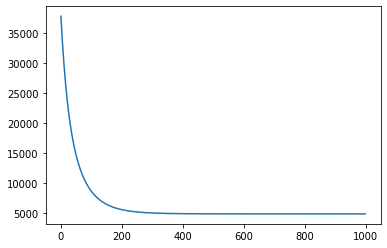

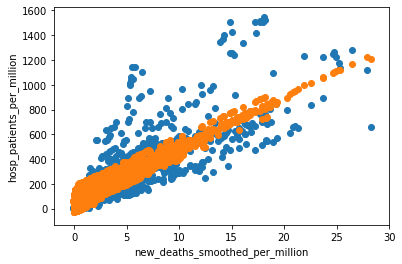

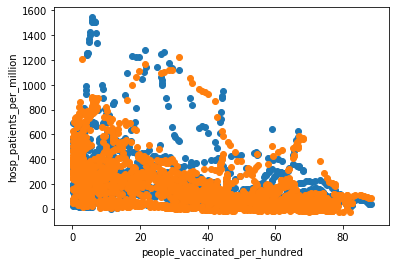

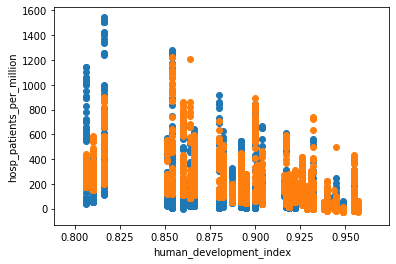

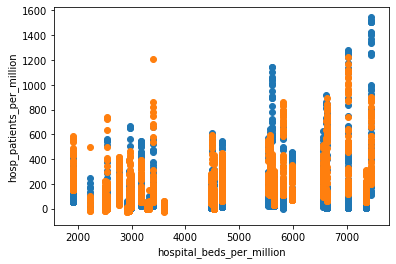

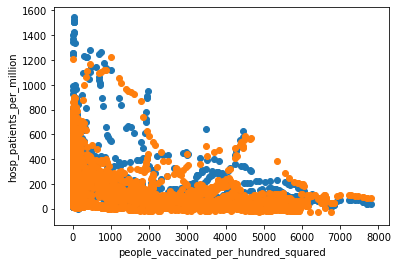

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred, human_development_index, hospital_beds_per_million, people_vaccinated_per_hundred_cubed**
1. r2_score is 0.7756060838916359
2. adjusted_r2_score is 0.7742443522810953

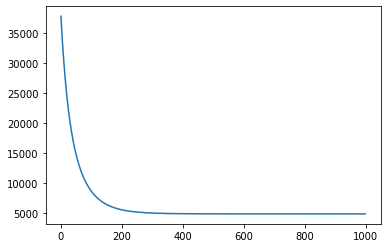

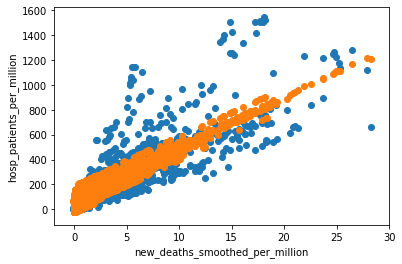

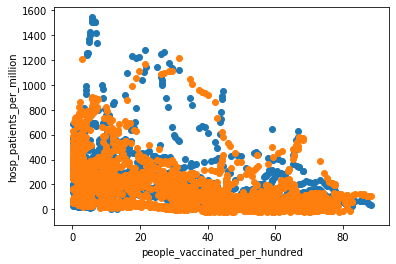

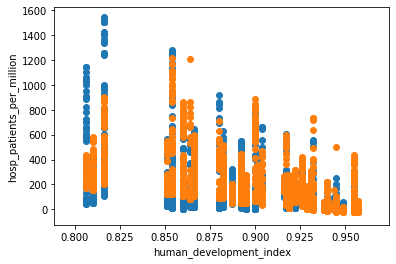

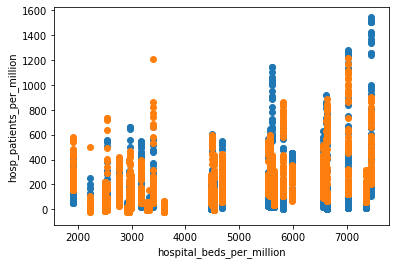

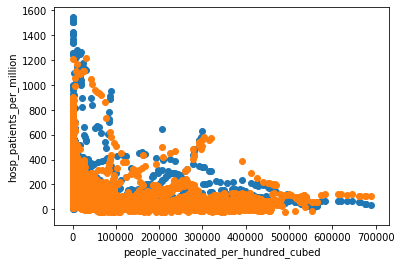

Features: **new_deaths_smoothed_per_million, people_vaccinated_per_hundred, human_development_index, hospital_beds_per_million, people_vaccinated_per_hundred_squared, people_vaccinated_per_hundred_cubed**
1. r2_score is 0.7756975872970827
2. adjusted_r2_score is 0.774336410973788

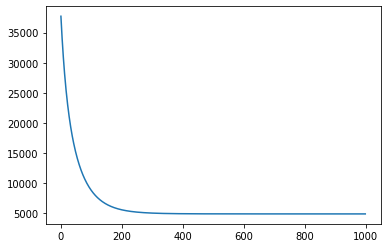

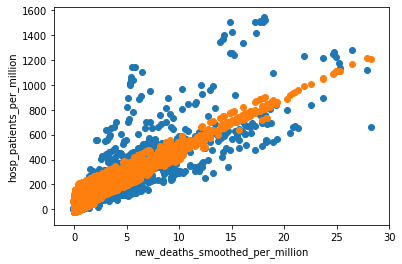

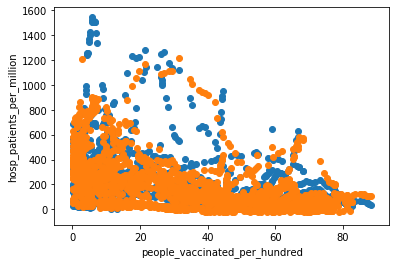

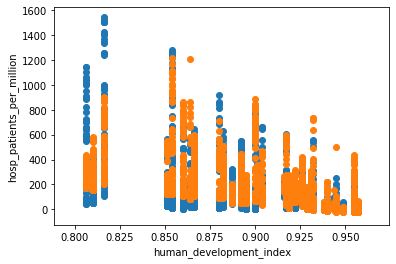

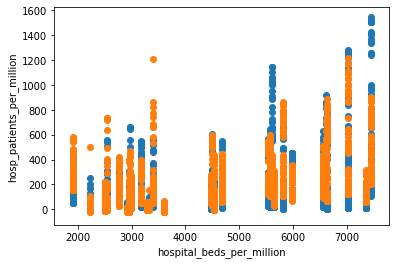

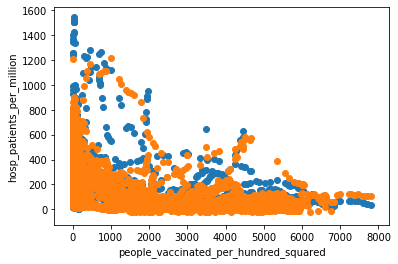

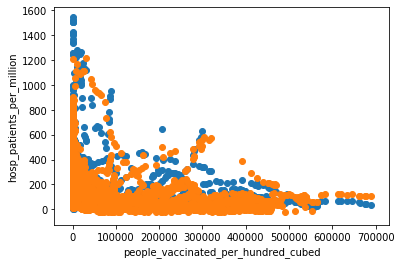

In [18]:
table = [["", "r2", "adjusted_r2"]]

features_with_squared = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "human_development_index", "hospital_beds_per_million", "people_vaccinated_per_hundred_squared"]
features_with_cubed = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "human_development_index", "hospital_beds_per_million", "people_vaccinated_per_hundred_cubed"]
features_with_squared_and_cubed = ["new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "human_development_index", "hospital_beds_per_million", "people_vaccinated_per_hundred_squared", "people_vaccinated_per_hundred_cubed"]

beta, r2, adjusted_r2 = lin_reg(df_dropna, features_with_squared, target_col=[dep_var], random_state=100)
table.append([f"With people_vaccinated_per_hundred_squared", r2, adjusted_r2])

beta, r2, adjusted_r2 = lin_reg(df_dropna, features_with_cubed, target_col=[dep_var], random_state=100)
table.append([f"With people_vaccinated_per_hundred_cubed", r2, adjusted_r2])

beta_final, r2, adjusted_r2 = lin_reg(df_dropna, features_with_squared_and_cubed, target_col=[dep_var], random_state=100)
table.append([f"With both squared and cubed", r2, adjusted_r2])



# Further refinements <a id="further-refinements-2"></a>

In an attempt to reduce random error, the original dataset was processed as follows:
1. Take the 1-month mean for each country
2. Return new df

## Insufficient values
After refining the data, we observe the `adjusted_r2_score` varying dramatically between 0.3304480772118046 and 0.835834817475537 as shown by the values of `min_val_adjusted` and `max_val_adjusted`. This is likely because there is insufficient data points available. The number of data points dropped drastically from 7743 to 333.

In contrast, before the data was processed, the `min_val_adjusted` and `max_val_adjusted` varied between a much smaller margin of 0.7501194536311047 and 0.8067240464695662.

[Back To Top](#contents)

In [19]:
# Retrieve a new dataframe that calculates the mean across a 1-month period for each country
df_monthly_mean = format_df(df_dropna)

print(f"Number of data points before processing is {df_dropna.shape[0]} while the number of data points after processing is {df_monthly_mean.shape[0]}")

Number of data points before processing is 7743 while the number of data points after processing is 333


In [20]:
def get_min_and_max_r2(df, features, iterations):
    '''
    Return the variation in r2 and adjusted_r2 scores
    '''
    min_val = float("inf")
    max_val = -float("inf")
    min_val_adjusted = float("inf")
    max_val_adjusted = -float("inf")
    
    for _ in range(iterations):
        r2, adjusted_r2 = lin_reg(df, features, random_state=None, show_data_plot=False)
        min_val = min(r2, min_val)
        min_val_adjusted = min(adjusted_r2, min_val_adjusted, random_state=None)
        max_val = max(adjusted_r2, max_val)
        max_val_adjusted = max(adjusted_r2, max_val_adjusted, random_state=None)
        
    print(f"Adjusted r2 values vary between {min_val_adjusted} and {max_val_adjusted}")
        
    return (min_val, min_val_adjusted, max_val, max_val_adjusted)

Run the following cell to find the min_val_adjusted and max_val_adjusted accordingly.

Note: The cell has been commented out as it may take 1-3 minutes to run.

In [21]:
# iterations = 500

# # Before refining dataset
# get_min_and_max_r2(df_dropna, features_with_squared_and_cubed, iterations)

# # After refining dataset
# get_min_and_max_r2(df_monthly_mean, features_with_squared_and_cubed, iterations)

# Conclusion <a id="conclusion-2"></a>

## Final model
Our final multivariate linear regression model has an `adjusted_r2_score` of 0.7743364109737879. This is ~0.5 more than a simple linear correlation model (Highest value obtained was 0.7287944820623531) and it consists of the following independent variables:
1. `new_deaths_smoothed_per_million` 
2. `people_vaccinated_per_hundred`
3. `human_development_index` 
4. `hospital_beds_per_million` 
5. `people_vaccinated_per_hundred_squared`
6. `people_vaccinated_per_hundred_cubed`

## Analysis

1. The daily deaths smoothed across 7 days was far more linearly correlated as compared to the daily cases smoothed across 7 days. This is expected since patients passing on due to COVID-19 would be far more likely to have been hospitalised. Also, a large proportion of individuals with COVID-19 experience only mild symptoms that do not require hospitalisation. Furthermore, since we are only considering countries with high human development index, it is safe to assume that any individuals experiencing severe symptoms due to COVID-19 would have access to a hospital to get proper medical treatment.
2. Having a high human development index caused a significant jump in linear correlation. This further validates our hypothesis that the higher the human development index, the more likely patients with severe COVID-19 symptoms would have had access to proper medical treatment within a hospital before passing on. In other words, patients within countries with a higher human development index are more likely to find themselves passing on within the hospital.
3. The vaccination rate of a country is non-linearly correlated to the number of individuals hospitalised. More complex polynomial regression should be conducted to obtain a more accurate model between the vaccination rate and number of individuals hospitalised.

As cautioned in Task 1 though, correlation does not equate to causation and more in-depth experimental trials and analysis ought to be conducted to validate the hypotheses outlined above.

[Back To Top](#contents)

# Appendix <a id="appendix"></a>

# Replacing missing values via forward propagation <a id="replace-1"></a>


## Reproduction rate
1. r2_score is -6.392753582384891e-05
2. adjusted_r2_score is -0.0003204462675572284 (DECREASED from 0.03740407903444909)

## People vaccinated per hundred
1. r2_score is 0.004205067263488016
2. adjusted_r2_score is 0.003949643538885161 (DECREASED from 0.21997546464365736)

## People fully vaccinated per hundred
1. r2_score is 0.006019635166130466
2. adjusted_r2_score is 0.00576467688243032 (DECREASED from 0.1730855138923163)

## ICU patients per million
1. r2_score is 0.006595121327647613
2. adjusted_r2_score is 0.006340310657490966 (DECREASED from 0.592940113924265)

## Stringency index
1. r2_score is 0.01671749289046609
2. adjusted_r2_score is 0.016465278632242786 (DECREASED from 0.1103046673899103)

## Extreme poverty
1. r2_score is 0.019816891055664754
2. adjusted_r2_score is 0.019565471800305323 (INCREASED from 0.012765814940187359)

## Human development index
1. r2_score is 0.039726039188433315
2. adjusted_r2_score is 0.03947972667604127 (DECREASED from 0.06123728635004533)

## Median age
1. r2_score is 0.046472998003899924
2. adjusted_r2_score is 0.04622841610219253 (INCREASED from -0.002810942157140728)


## Analysis
As shown, the univariate linear regression against all but two variables experienced a drop in `adjusted_r2_score`


[Back To Top](#contents)

Number of data points before dropping missing values is 132016 while the number of data points after dropping missing values is 129991


Features: **icu_patients_per_million**
1. r2_score is 0.006595121327647613
2. adjusted_r2_score is 0.006340310657490966

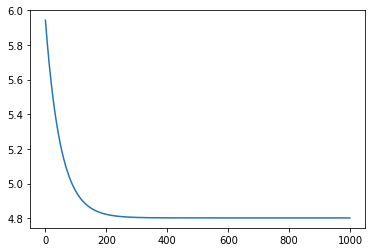

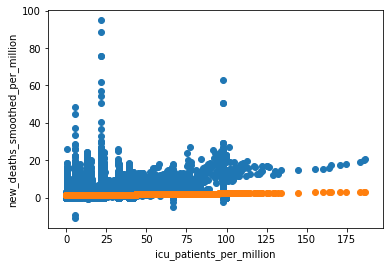

Features: **new_cases_smoothed_per_million**
1. r2_score is 0.4057454742477602
2. adjusted_r2_score is 0.4055930465748129

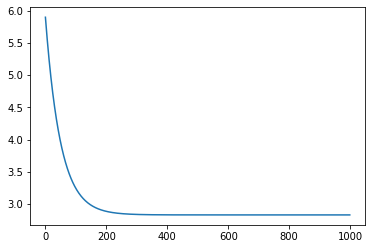

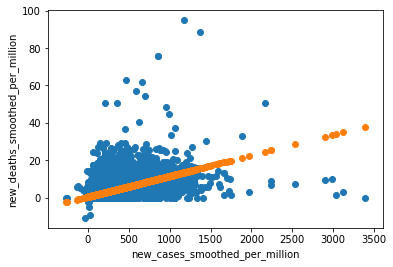

Features: **stringency_index**
1. r2_score is 0.01671749289046609
2. adjusted_r2_score is 0.016465278632242786

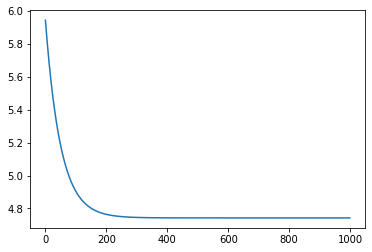

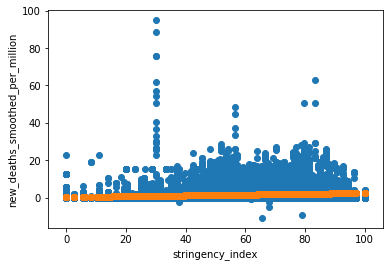

Features: **median_age**
1. r2_score is 0.046472998003899924
2. adjusted_r2_score is 0.04622841610219253

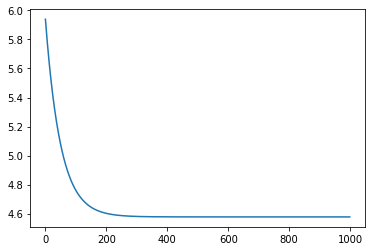

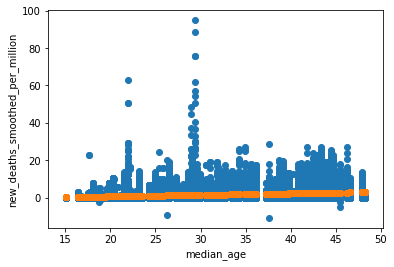

Features: **extreme_poverty**
1. r2_score is 0.019816891055664754
2. adjusted_r2_score is 0.019565471800305323

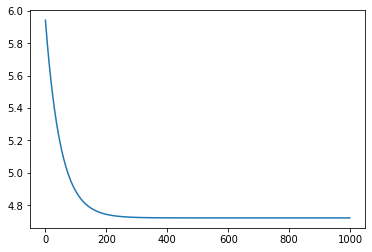

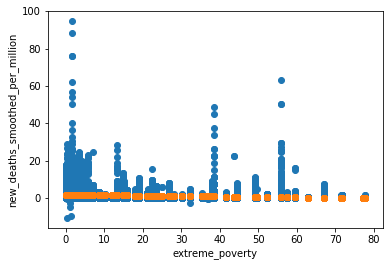

Features: **people_fully_vaccinated_per_hundred**
1. r2_score is 0.006019635166130466
2. adjusted_r2_score is 0.00576467688243032

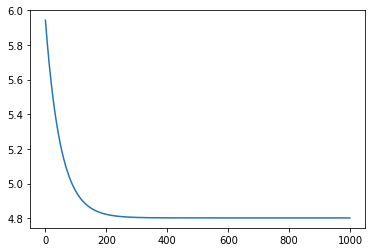

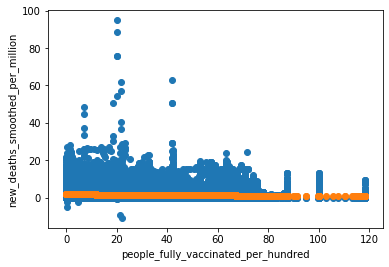

Features: **people_vaccinated_per_hundred**
1. r2_score is 0.004205067263488016
2. adjusted_r2_score is 0.003949643538885161

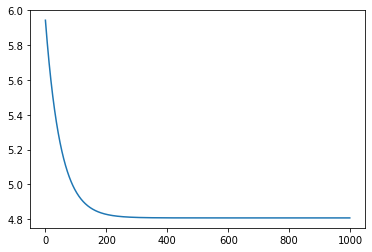

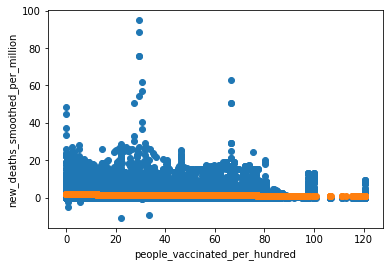

Features: **reproduction_rate**
1. r2_score is -6.392753582384891e-05
2. adjusted_r2_score is -0.0003204462675572284

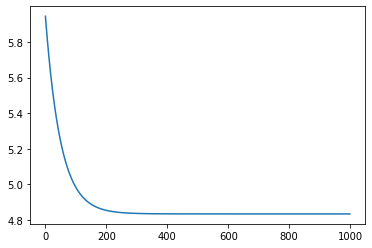

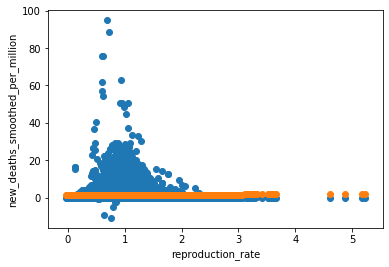

Features: **human_development_index**
1. r2_score is 0.039726039188433315
2. adjusted_r2_score is 0.03947972667604127

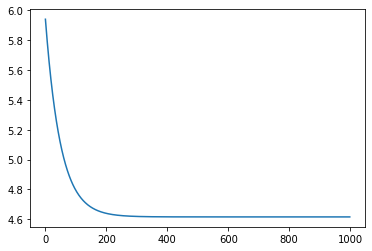

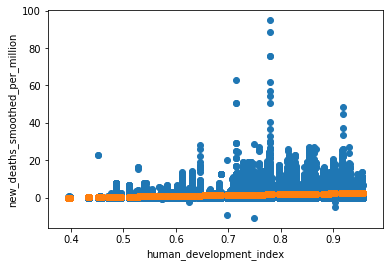

In [22]:
useful_cols = ["icu_patients_per_million", "new_cases_smoothed_per_million", "stringency_index", "median_age", "extreme_poverty", "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "reproduction_rate", "human_development_index", "new_deaths_smoothed_per_million"]

df_useful = df[useful_cols]

# Forward fill
df_fillna = df_useful.fillna(method="ffill").dropna()

print(f"Number of data points before dropping missing values is {df_useful.shape[0]} while the number of data points after dropping missing values is {df_fillna.shape[0]}")

independent_var = ["icu_patients_per_million", "new_cases_smoothed_per_million", "stringency_index", "median_age", "extreme_poverty", "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "reproduction_rate", "human_development_index"]
for feature in independent_var:
    lin_reg(df_fillna, [feature], random_state=100)
    


# Spotting linear correlation between independent variables - Task 1  <a id='heatmap-1'></a>

1. Reorder columns so that correlation values with respect to `new_deaths_smoothed_per_million` is easier to visualise
2. Drop unnamed columns
3. Get correlation between all variables and sort according to our dependent variable, `new_deaths_smoothed_per_million`
4. Plot heatmap

[Back To Top](#contents)

In [23]:
useful_cols = ["icu_patients_per_million", "new_cases_smoothed_per_million", "stringency_index", "median_age", "extreme_poverty", "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "reproduction_rate", "human_development_index", "new_deaths_smoothed_per_million"]

df_appendix_one = df[useful_cols]

# Drop rows with nan
df_appendix_one = df_appendix_one.dropna()

# Get columns
cols = df_appendix_one.columns.tolist()

# Initialise dependent variable
dep_var = "new_deaths_smoothed_per_million"

# Reorder columns
idx = cols.index(dep_var)
cols = [cols[idx]] + cols[:idx] + cols[idx+1:]
df_appendix_one = df_appendix_one[cols]

# Sort and plot heatmap
corr=df_appendix_one.corr()
corr = corr.sort_values(dep_var, ascending=False)
corr.style.background_gradient(cmap='coolwarm')

,new_deaths_smoothed_per_million,icu_patients_per_million,new_cases_smoothed_per_million,stringency_index,median_age,extreme_poverty,people_fully_vaccinated_per_hundred,people_vaccinated_per_hundred,reproduction_rate,human_development_index
new_deaths_smoothed_per_million,1,0.784022,0.522284,0.34799,0.0603279,0.164107,-0.437565,-0.490619,-0.219432,-0.261602
icu_patients_per_million,0.784022,1,0.484281,0.365199,0.0777443,0.249135,-0.466989,-0.500051,-0.196164,-0.265752
new_cases_smoothed_per_million,0.522284,0.484281,1,0.116186,-0.189589,-0.141491,-0.0816488,-0.128216,0.0924398,0.0411783
stringency_index,0.34799,0.365199,0.116186,1,-0.0293737,-0.00186937,-0.573006,-0.496035,-0.25551,-0.0125863
extreme_poverty,0.164107,0.249135,-0.141491,-0.00186937,0.271477,1,-0.146773,-0.203858,0.000610432,-0.465829
median_age,0.0603279,0.0777443,-0.189589,-0.0293737,1,0.271477,-0.101287,-0.0869097,-0.0256217,0.0231753
reproduction_rate,-0.219432,-0.196164,0.0924398,-0.25551,-0.0256217,0.000610432,0.157577,0.0937544,1,0.0144216
human_development_index,-0.261602,-0.265752,0.0411783,-0.0125863,0.0231753,-0.465829,0.208638,0.269556,0.0144216,1
people_fully_vaccinated_per_hundred,-0.437565,-0.466989,-0.0816488,-0.573006,-0.101287,-0.146773,1,0.949334,0.157577,0.208638
people_vaccinated_per_hundred,-0.490619,-0.500051,-0.128216,-0.496035,-0.0869097,-0.203858,0.949334,1,0.0937544,0.269556


# Spotting linear correlation between independent variables - Task 2  <a id='heatmap-2'></a>

1. Reorder columns so that correlation values with respect to `hosp_patients_per_million` is easier to visualise
2. Drop unnamed columns
3. Get correlation between all variables and sort according to our dependent variable, `hosp_patients_per_million`
4. Plot heatmap

[Back To Top](#contents)

In [24]:
useful_cols = ["location", "date", "new_cases_smoothed_per_million", "new_deaths_smoothed_per_million", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred", "population_density", "human_development_index", "stringency_index", "hospital_beds_per_thousand", "hosp_patients_per_million"]

df_appendix_two = df[useful_cols]

new_col = df_appendix_two.loc[:, "hospital_beds_per_thousand"] * 1000

df_appendix_two.insert(df_appendix_two.shape[1]-2, "hospital_beds_per_million", new_col)

# Drop rows with nan
df_appendix_two = df_appendix_two.dropna()

# Get columns
cols = df_appendix_two.columns.tolist()

# Initialise dependent variable
dep_var = "hosp_patients_per_million"

# Reorder columns
idx = cols.index(dep_var)
cols = [cols[idx]] + cols[:idx] + cols[idx+1:]
df_appendix_two = df_appendix_two[cols]

# Sort and plot heatmap
corr=df_appendix_two.corr()
corr = corr.sort_values(dep_var, ascending=False)
corr.style.background_gradient(cmap='coolwarm')


,hosp_patients_per_million,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population_density,human_development_index,stringency_index,hospital_beds_per_million,hospital_beds_per_thousand
hosp_patients_per_million,1,0.628674,0.856171,-0.477066,-0.431353,-0.124462,-0.448377,0.338687,0.332182,0.332182
new_deaths_smoothed_per_million,0.856171,0.589066,1,-0.486664,-0.444455,-0.08673,-0.294849,0.432742,0.242353,0.242353
new_cases_smoothed_per_million,0.628674,1,0.589066,-0.209213,-0.151876,-0.0292768,-0.0956022,0.232537,0.0126879,0.0126879
stringency_index,0.338687,0.232537,0.432742,-0.540585,-0.595156,0.00435807,0.0407263,1,-0.194403,-0.194403
hospital_beds_per_thousand,0.332182,0.0126879,0.242353,-0.179665,-0.122896,-0.0243768,-0.364493,-0.194403,1,1
hospital_beds_per_million,0.332182,0.0126879,0.242353,-0.179665,-0.122896,-0.0243768,-0.364493,-0.194403,1,1
population_density,-0.124462,-0.0292768,-0.08673,0.152459,0.155383,1,0.0521013,0.00435807,-0.0243768,-0.0243768
people_fully_vaccinated_per_hundred,-0.431353,-0.151876,-0.444455,0.949622,1,0.155383,0.126575,-0.595156,-0.122896,-0.122896
human_development_index,-0.448377,-0.0956022,-0.294849,0.178862,0.126575,0.0521013,1,0.0407263,-0.364493,-0.364493
people_vaccinated_per_hundred,-0.477066,-0.209213,-0.486664,1,0.949622,0.152459,0.178862,-0.540585,-0.179665,-0.179665
